# TO DO
 - add a different metric
  - less groups strata
 - 400 -1000 nm
  
 - change nb of strata to 5 and recompute cache!
 -  try more data for P and K
 - investigate phosphorus major underperformance on usda
 -  improve (fix) 2d stratification (the classes are extremely imbalanced) (suspended - hard problem)
 - update model partitioning with cv and maybe stratification, try PLSR
 - look for sources on how they select samples to add to the dataset - w said they don't just take all, and we saw that the subset chosen strongly influences the result
 - learning curves when keeping the test set constant ( in progress)
 - explore the limits of lcurves - what is the absolute minimum mb of samples if they are chosen extremely carefully? run a gigantic search over everything that comes to mind to try to find a really small training set that works
 - also exactly the opposite, try to recreate what happened with P with the usda_easy data or N with analyte data for N (or whatever it was exactly)
 - just take the geographically small subset already
 - explore outliers removal impact on lcs (quantile and prelimirany performance based)
 - choosing a subset of frequencies - this should definitely accelerate learning

# report writing

add two more features - different number of strata, learning curves - one pretty plot otherwise report as tables
- maybeeeeeee try stratifying by multiple dimensions one more time - how about just 4 categories for two dimensions?
 - maybeeeeeeeeeeee ** 2 try predefined stratification thresholds which would simulate real world survey 


# questions

1. how do they select which samples to add to the calibration set?
2. do we care about different metrics or only r2?

In [2]:
print("dupa")

dupa


In [3]:
import pandas as pd
import attr
import numpy as np
import geopandas as gpd
import os
from shapely.affinity import scale
from shapely.geometry import Point, Polygon
import plotly.express as px
import matplotlib.pyplot as plt
from pandas import DataFrame as DF, Series as S
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from peakutils import baseline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression  # noqa: E402
from sklearn.ensemble import (  # noqa: E402
    ExtraTreesRegressor,  # noqa: E402
)
from scipy.signal import savgol_filter
import funcy
import random
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
from caching import Cache
from sklearn.cluster import KMeans
import seaborn as sns
from functools import lru_cache, reduce
from custom_split import GroupKFold, StratifiedKFold, KFold
import scipy
from scipy.special import kl_div
#   plot principial components
#  take subset in the PC space of US data
# impact of variety of the data (stratification) on learning curves. Do we need less samples as long as they are diverse enough?




sns.set(rc={'figure.figsize':(11.7,8.27)})


def assert_unreachable(x):
    raise AssertionError(f"Entered a code path that should not be reachable, argument value: {x!r}")

def normalize(df):
    return (df - df.mean()) / df.std()

def unskew(s, threshold=1.5):
    eps = 1e-5
    while skew(s) >= threshold:
        s = s - min(s)
        s = np.log(1 + s)
    return s

def detect_outliers(df_or_s, method="quantile", quantile=0.97, std_mult=3):
    if method == "quantile":
        upper = df_or_s.quantile(quantile)
        lower = df_or_s.quantile(1 - quantile)
        outliers = (df_or_s >= upper) | (df_or_s <= lower)
    elif method == "std":
        outliers = (df_or_s - df_or_s.mean()).abs() >= std_mult * df_or_s.std()
    else:
        assert_unreachable(method)
    return outliers

def drop_outliers(df_or_s, method="quantile",quantile=0.97, std_mult=3):
    df_or_s = df_or_s.copy()
    len_before = len(df_or_s.index)
    outliers = detect_outliers(df_or_s, method, quantile, std_mult)
    if isinstance(df_or_s, DF):
        outliers = outliers.any(axis=1)
    df_or_s = df_or_s[~outliers]
    len_after = len(df_or_s.index)
    print(f"dropped {len_before - len_after} rows")
    return df_or_s


def clean_wcdf(wcdf_raw):
    wcdf_values = wcdf_raw.iloc[:,1:]
    wcdf_unskewed = wcdf_values.apply(unskew)
    wcdf_norm = normalize(wcdf_unskewed)
    wcdf = drop_outliers(wcdf_norm, method="quantile", quantile=0.99)
    return wcdf


def get_clean_wcdf():
    wcdf_raw = pd.read_csv('../sis_dataset/sis_dataset/wetchem.csv')
    return clean_wcdf(wcdf_raw)


DEV = False
DEBUG = True
cached = Cache(DEV, debug=DEBUG)

SEED = 667788

if DEV:
#     N_JOBS = 1
    SEEDS = (SEED, )
else:
    N_JOBS = 8
    SEEDS = (SEED, ) # for now 
    
N_JOBS = 8


/home/bart2/test_venv/.venv/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [144]:
DATA_DIR = '/media/Data/jp_dir/sis/usda/extracted_metadata'
DRY_PATH = '/media/Data/jp_dir/sis/usda/soil-usda/mir.csv'


def get_all_dry_usda():
    try:
        global DRY_DF
        return DRY_DF

    except NameError:
        print("reading dry usda...")
        DRY_DF = pd.read_csv(DRY_PATH)
        return DRY_DF


ANALYTE_TO_FILE = {
    "P2": "p_274_measured_mir.csv", # olsen extractable, sis uses this one (not really it uses two different methods)
    "P6": "p_652_measured_mir.csv", # melich 3 extractable
    "K": "k_725_measured_mir.csv",
    "N": "n_623_measured_mir.csv",
    "pH": "ph_soilwater_measured_mir.csv",
    "C": "c_622_measured_mir.csv",
}

ANALYTE_TO_PATH = {
    "clay": "~/extracted_data/clay.csv",
    "water": "~/extracted_data/water_417.csv",
    "location": "~/data/usda_loc.csv"
}

def move_col_to_front(df, col):
    return df[[col] + [c for c in df.columns if c != col] ]


def get_usda_wet_analyte(analyte, keep_spec="first"):
    try:
        filename = ANALYTE_TO_FILE[analyte]
        path = os.path.join(DATA_DIR, filename)
    except KeyError:
        path = ANALYTE_TO_PATH[analyte]
    df = pd.read_csv(path)
    if keep_spec == "filter":
        df = df[df["scan_path_name"].str[-1] == "0"]
        keep_spec = "first"
    df = df.drop_duplicates("smp_id", keep=keep_spec)
    df["scan_id"] = df["scan_path_name"].str.split(".").str[0]
    df = df.drop(columns=["scan_path_name", "units_of_measure", "soil_property_name"], errors="ignore")
    df = df.rename(columns={'value_of_measured_property': analyte})
    return df

def get_location_df():
        return pd.read_csv(ANALYTE_TO_PATH["location"]).dropna()
    
def get_usda_wet_analytes(analytes, keep_spec="first"):
    if isinstance(analytes, str):
        analytes = [analytes]
    
    
    dfs = [get_usda_wet_analyte(a, keep_spec=keep_spec) for a in analytes]
    return  reduce(lambda x, y: x.merge(y, how='inner', on=["scan_id", "smp_id"]), dfs)
    


@cached("get_usda_analyte_df")
def get_usda_analyte_df(analytes, size=5000, seed=SEED, keep_spec="first"):
    if isinstance(analytes, str):
        analytes = [analytes]
    analytes = list(set(analytes))
    
    if DEV:
        size = 1000
    loc_df = None
    
    if "location" in analytes or "lat_site" in analytes or "long_site" in analytes:
        analytes = set(analytes)
        analytes -= {"location", "lat_site", "long_site"}
        analytes = list(analytes)
        loc_df = get_location_df()
        
    wet_df = get_usda_wet_analytes(analytes, keep_spec=keep_spec)
    dry_df = get_all_dry_usda()

    joined = wet_df.merge(dry_df, how='inner', left_on="scan_id", right_on="Unnamed: 0")
    joined = joined.drop(columns = [
                                    "scan_id", 
                                    "Unnamed: 0",
                                   ]
                         )
    if loc_df is not None:
        joined = joined.merge(loc_df, how='inner', on="smp_id")
        joined = move_col_to_front(joined, "lat_site")
        joined = move_col_to_front(joined, "long_site")
        joined = move_col_to_front(joined, "smp_id")
        
    if size == "all":
        print(f"size: {len(joined.index)}")
        return joined

    size = min(size, len(joined.index))
    print(f"size: {size}")
    return joined.sample(size, random_state=seed)
    
    

In [145]:
def keep_newest_version(dry):
    dry = dry.sort_values('version', ascending=False).drop_duplicates("id")
    dry = dry.sort_values('id')
    dry = dry.drop(columns=["version"])
    return dry


def drop_zero_absorbance(vs):
    outliers = (vs < 0.5).all(axis=1)
    return vs[~outliers]

def remove_baseline(vs) -> np.ndarray:
    base = np.apply_along_axis(lambda x: baseline(x, 2), 0, vs)
    base = np.mean(base, axis=0)
    vs = vs - base
    return vs

def gradients(x: np.ndarray) -> np.ndarray:
    return np.apply_along_axis(np.gradient, 1, x)

def smoothing(x: np.ndarray, window_size=51, order=3) -> np.ndarray:
    return savgol_filter(x, window_size, order, axis=1)

def remove_CO2_freqs(df: DF) -> DF:
    # outdated
    assert False
    freqs = df.columns.astype(float)
    retain = (freqs <= 2268) | (freqs >= 2389) # taken from one of the papers
    return df[df.columns[retain]]

def snv(x):
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1)



In [146]:

def get_raw_sis():
    wet_sis_raw = pd.read_csv('../data/wetchem.csv')
    dry_sis_raw = pd.read_csv('../data/drychem.csv')
    dry_sis = keep_newest_version(dry_sis_raw)
    result = wet_sis_raw.set_index("id").join(dry_sis.set_index("id"), how="inner").reset_index()
    if DEV:
        result = result.sample(frac=0.05, random_state=SEED)
    return result

def spec_cols_mask(df):
    mask = df.columns.str.match("[0-9]+\.[0-9]+")
    return mask

def spec_cols(df):
    return df.iloc[:, spec_cols_mask(df)]

def spec_cols_names(df):
    return df.columns[spec_cols_mask(df)]


def transform_specs(df, f):
    df = df.copy()
    x = spec_cols(df)
    x_transformed = DF(f(x), columns=df.columns[spec_cols_mask(df)])
    return pd.concat([df.loc[:, ~spec_cols_mask(df)].reset_index(drop=True), x_transformed], axis=1)


def get_model_data(df, analyte, stratify=None):
    train, test = train_test_split(df, test_size=0.2, stratify=stratify, random_state=SEED)
    X_train, y_train = spec_cols(train), train[analyte]
    X_test, y_test = spec_cols(test), test[analyte]
    return (X_train, y_train, X_test, y_test)

def score_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

@cached("get_clean_sis")
def get_clean_sis(transforms=(smoothing, gradients, remove_baseline)):
    df = get_raw_sis()
    transform = funcy.compose(*transforms)
    df = transform_specs(df, transform)
    return df
    
def xtrees_factory():
    return ExtraTreesRegressor(n_jobs=N_JOBS, random_state=SEED, 
                               **{'n_estimators': 300, 'max_features': 'auto', 'max_depth': 50})

def plsr_factory():
    return PLSRegression()






In [147]:
def clip_outliers(x, lower=1, upper=99):
    l_perc = np.percentile(x, lower)
    u_perc = np.percentile(x, upper)
    return np.clip(x, l_perc, u_perc)


def identity(x):
    return x

def get_clipped_model(model):
    return TransformedTargetRegressor(
        regressor=model,
        func=clip_outliers,
        inverse_func=identity,
        check_inverse=False
    )

In [148]:
# clipped_model = get_clipped_model(xtrees_factory())
# score_model(clipped_model, *sis_data)

# this was a failure anyway

# Compare with USDA

In [149]:
def get_raw_clay():
    clay_raw = pd.read_csv("../data/usda_clay_water.csv")
    if DEV:
        return clay_raw.sample(frac=0.1, random_state=SEED).reset_index(drop=True)
    else:
        return clay_raw

@cached("get_clean_clay_df")
def get_clean_clay_df():
    clay_raw = get_raw_clay()
    return transform_specs(clay_raw, funcy.compose(smoothing, gradients, remove_baseline))




def drop_outliers_for_analyte(df, analyte, method="quantile", quantile=0.99, std_mult=3):
    s = df[analyte]
    if method == "quantile":
        upper = s.quantile(quantile)
        lower = s.quantile(1 - quantile)
        outliers = (s >= upper) | (s <= lower)
    elif method == "std":
        outliers = (s - s.mean()).abs() >= std_mult * s.std()
        
    return df[~outliers]

@cached("get_clean_analyte_df")
def get_clean_analyte_df(analytes, size=5000, seed=SEED, keep_spec="first", target=None):
    if isinstance(analytes, str):
        target = analytes
        analytes = [analytes]
        
    assert target is not None
        
    analytes = list(set(analytes))
    print(f"collecting data for {analytes}...")
    if target:
        if isinstance(size, int):
            n = size
            size = int(size * 1.03)
            
        raw = get_usda_analyte_df(analytes, size, seed, keep_spec=keep_spec)
        raw = drop_outliers_for_analyte(raw, target)
        if isinstance(size, int):
            raw = raw.sample(n=min(n, len(raw.index)))
    else:
        raw = get_usda_analyte_df(analytes, size, seed, keep_spec=keep_spec)

    print(f"size after droping: {len(raw.index)}")
    print("preprocessing specs...")
    return transform_specs(raw, funcy.compose(smoothing, gradients, remove_baseline))


def standard_clean(raw):
    return transform_specs(raw, funcy.compose(smoothing, gradients, remove_baseline))


clay_df = get_clean_clay_df()
raw_clay_df = get_raw_clay()

getting cached cache/prod/get_clean_clay_df/##e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855


In [10]:
get_clean_analyte_df("N", target="N")

getting cached cache/prod/get_clean_analyte_df/N#target:N#15c841dff8407a197a8be456d43283d973c0ba690724b24da5e5d0d6dbc70423


,smp_id,N,4001.65608,3999.72758,3997.79907,3995.87056,3993.94205,3992.01354,3990.08503,3988.15652,...,617.12287,615.19436,613.26585,611.33734,609.40883,607.48032,605.55181,603.6233,601.69479,599.76629
0,207388,0.377000,-0.000031,-0.000040,-0.000047,-0.000054,-0.000060,-0.000066,-0.000070,-0.000075,...,-0.008059,-0.008613,-0.009207,-0.009844,-0.010527,-0.011261,-0.012048,-0.012891,-0.013794,-0.014760
1,166754,0.093000,0.000013,-0.000008,-0.000026,-0.000041,-0.000054,-0.000065,-0.000074,-0.000081,...,0.001436,0.001675,0.001973,0.002332,0.002757,0.003253,0.003823,0.004472,0.005203,0.006021
2,208704,0.207592,0.000336,0.000340,0.000344,0.000346,0.000348,0.000349,0.000350,0.000350,...,-0.007209,-0.007375,-0.007492,-0.007556,-0.007565,-0.007517,-0.007407,-0.007235,-0.006996,-0.006689
3,74960,0.581966,-0.000056,-0.000050,-0.000044,-0.000040,-0.000037,-0.000034,-0.000033,-0.000033,...,-0.003371,-0.003470,-0.003552,-0.003615,-0.003659,-0.003685,-0.003690,-0.003676,-0.003641,-0.003585
4,261606,0.050159,-0.003523,-0.003035,-0.002588,-0.002181,-0.001813,-0.001481,-0.001184,-0.000921,...,0.002581,0.002944,0.003367,0.003855,0.004412,0.005043,0.005752,0.006542,0.007419,0.008386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,200797,0.100768,0.000656,0.000614,0.000576,0.000542,0.000511,0.000484,0.000460,0.000439,...,-0.011780,-0.011868,-0.011927,-0.011956,-0.011959,-0.011934,-0.011883,-0.011807,-0.011707,-0.011583
4996,71900,0.064612,-0.000009,0.000005,0.000019,0.000032,0.000043,0.000054,0.000063,0.000072,...,-0.004792,-0.004898,-0.004995,-0.005086,-0.005171,-0.005250,-0.005325,-0.005397,-0.005466,-0.005535
4997,164444,1.159799,0.000134,0.000065,0.000003,-0.000053,-0.000103,-0.000147,-0.000186,-0.000220,...,-0.008207,-0.008522,-0.008850,-0.009193,-0.009552,-0.009932,-0.010333,-0.010759,-0.011211,-0.011692
4998,106065,0.036920,0.000045,0.000056,0.000067,0.000076,0.000084,0.000090,0.000096,0.000101,...,-0.003864,-0.004020,-0.004150,-0.004252,-0.004322,-0.004359,-0.004361,-0.004325,-0.004249,-0.004131


In [11]:
def get_raw_usda():
    result = pd.read_csv('../data/usda_easy.csv')
    if DEV:
        return result.sample(frac=0.05, random_state=SEED).reset_index(drop=True)
    else:
        return result
    
def get_raw_clay():
    clay_raw = pd.read_csv("../data/usda_clay_water.csv")
    if DEV:
        return clay_raw.sample(frac=0.1, random_state=SEED).reset_index(drop=True)
    else:
        return clay_raw

@cached("get_clean_clay_df")
def get_clean_clay_df():
    clay_raw = get_raw_clay()
    return transform_specs(clay_raw, funcy.compose(smoothing, gradients, remove_baseline))

clay_df = get_clean_clay_df()
raw_clay_df = get_raw_clay()

getting cached cache/prod/get_clean_clay_df/##e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855


In [12]:
@cached("get_clean_usda")
def get_clean_usda():
    raw_usda = get_raw_usda()
    print("cleaning usda...")
    return transform_specs(raw_usda, funcy.compose(smoothing, gradients, remove_baseline))



usda = get_clean_usda()
usda_raw = get_raw_usda()

getting cached cache/prod/get_clean_usda/##e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855


In [13]:
from functools import reduce

@cached("cv_score")
def cv_score(df, 
             analyte,
             stratify=None,
             model_factory=xtrees_factory,
             random_state=SEED, 
             adverse=False,
             train_subset_size=1.0):
    
    n = len(df.index)
    if isinstance(train_subset_size, int):
        train_subset_size = train_subset_size / n
    
    df = df.sample(frac=1, random_state=random_state) # random shuffle
    model = model_factory()
    X = spec_cols(df)
    y = df[analyte]
    if stratify:
        if isinstance(stratify, (str, tuple, list, MultiStrat, ClusterStrat)):
            stratify = strat_f(stratify)
        else:
            raise ValueError("functional stratification no longer supported")
        stratify_col = stratify(df)
        if adverse:
            gkf = GroupKFold(n_splits=S(stratify_col).nunique(), train_subset_frac=train_subset_size)
            cv = gkf.split(X, stratify_col, stratify_col)
        else:
            skf = StratifiedKFold(n_splits=5, train_subset_frac=train_subset_size)
            cv = skf.split(X, stratify_col)
    else:
        cv = KFold(train_subset_frac=train_subset_size)
    return cross_val_score(model, X, y, scoring="r2", cv=cv, n_jobs=N_JOBS)


def get_n_strata(n_cols):
    if DEV:
        n = 5
    else:
        n = 10 # TODO change to 5 andrecompute cache!

    n = int(n ** (1 / n_cols))
    return max(n, 2)


class MultiStrat(dict):
    @classmethod
    def from_list(cls, l):
        return cls({k: get_n_strata(len(l)) for k in l})
    
    
    
    

@attr.define
class ClusterStrat:
    strats_by: list
    nb_clusters: int


class OrderedStrat(list):
    pass

MS = MultiStrat
CS = ClusterStrat


def parse_strat(strat):
    if isinstance(strat, (MS, CS, OrderedStrat)):
        return strat
    elif isinstance(strat, str):
        return MultiStrat({strat: get_n_strata(1)})
    elif isinstance(strat, (tuple, list)):
        raise ValueError("Please use multi stratification explicitly")
    else:
        assert False, strat
        

    
def encode_tuple(t, sizes):
    assert len(t) == len(sizes)
    t = np.array(t)
    for i, size in enumerate(sizes):
        t[i+1:] *= size

    return sum(t)
        
        
def strat_f(strat):
    strat = parse_strat(strat)
    if isinstance(strat, ClusterStrat):
        return clustered_strat_f(strat)
    
    if isinstance(strat, OrderedStrat):
        return ordered_strat_f(strat)
    
    discretizer_c = lambda n: KBinsDiscretizer(n_bins=n, encode="ordinal", strategy="quantile")
    discretize = lambda n, x: discretizer_c(n).fit_transform(x.values.reshape(-1, 1)).flatten().astype(int)

    def quantile_strat_f(df):
        discretize_df = lambda col_n: discretize(col_n[1], df[col_n[0]])
        ys_discrete = list(map(discretize_df, strat.items()))
        ys_discrete = np.stack(ys_discrete, axis=1)
        return np.apply_along_axis(lambda x: encode_tuple(x, strat.values()), axis=1, arr=ys_discrete)


    return quantile_strat_f

def cartesian_strata_sizes(df, strat):
    assert isinstance(strat, MultiStrat)
    
    discretizer_c = lambda n: KBinsDiscretizer(n_bins=n, encode="ordinal", strategy="quantile")
    discretize = lambda n, x: discretizer_c(n).fit_transform(x.values.reshape(-1, 1)).flatten().astype(int)

    discretize_df = lambda col_n: discretize(col_n[1], df[col_n[0]])
    ys_discrete = list(map(discretize_df, strat.items()))
    ys_discrete = np.stack(ys_discrete, axis=1)
    strat_col = np.apply_along_axis(lambda x: encode_tuple(x, strat.values()), axis=1, arr=ys_discrete)
    return S(strat_col).value_counts().values

def norm_vector(v):
    return v / v.sum()


def kl_div_of_strat(df, strat):
    from scipy.special import rel_entr
    actual = norm_vector(cartesian_strata_sizes(df, strat))
    uniform = norm_vector(np.ones_like(actual))
    return rel_entr(actual, uniform).sum() * 1000



def clustered_strat_f(strat):
    def _strat_f(df):
        km = KMeans(n_clusters=strat.nb_clusters)
        km.fit(df[list(strat.strats_by)])
        return km.labels_
        
    return _strat_f


def discretize_series(x, n_bins):
    s = S(x)
    
    bin_size = len(s) / n_bins
    s = s.sort_values()
    for i in range(n_bins):
        s[int(i*bin_size): int((i + 1)*bin_size)] = i

    return s.sort_index()

def encode_cols_as_ordinal(*cols):
    cols = list(map(S, cols))
    df = pd.concat(cols, axis=1)
    unique_rows = df.drop_duplicates().reset_index(drop=True)
    return df.merge(unique_rows.reset_index(), sort=False, how="left")["index"].values

def ordered_strat_f(strat):
    ST_COL = "__STRAT_COL__"
    ST_COL2 = "__STRAT_COL2__"
    strat = list(strat)
    
    def recursive_strat_f(df, col_n_tuples):
        df = df.copy()
        if not col_n_tuples:
            return S(0, index=df.index).values
        
        col, n_bins = col_n_tuples.pop(0)
        df[ST_COL] = recursive_strat_f(df, col_n_tuples)
        subdfs = []
        for _, subdf in df.groupby(ST_COL):
            subdf = subdf.copy()
            subdf[ST_COL2] = discretize_series(subdf[col], n_bins)
            subdfs.append(subdf)
            

        df = pd.concat(subdfs, axis=0).sort_index()

        return encode_cols_as_ordinal(df[ST_COL], df[ST_COL2])

    
    def strat_f(df):
        return recursive_strat_f(df, strat)
    
    return strat_f
        
        
        
        
    

# Learning curves
## impact of different stratifications


## both training and test set stratified (using cross validation)

In [14]:


@cached("get_learning_curve")
def get_learning_curve(df, analyte, fracs, stratify=None, seeds=(SEED,), adverse=False):
    if adverse and not stratify:
        raise ValueError("adverserial stratification only possible with some stratification defined")
    scores = []
    for seed in seeds:
        df = df.sample(frac=1, random_state=seed)
        for frac in fracs:
            print(f"training on {frac} of the data with seed {seed}...")
            subset = df.iloc[:int(frac * len(df.index)), :]
            subset_scores = cv_score(subset, analyte, stratify=stratify, random_state=seed, adverse=adverse)
            for score in subset_scores:
                scores.append((frac, score))

    return DF(scores, columns=["frac", "score"])

@cached("get_lc_geo")
def get_lc_geo(df, analyte, rate=0.3, stratify=None, seeds=(SEED,), adverse=False, min_size=0.12, max_size=1, manual_sizes=None):
    # this is really just because of caching
    fracs = geo_sizes(rate, min_size, max_size)
    if adverse and not stratify:
        raise ValueError("adverserial stratification only possible with some stratification defined")
        
    if manual_sizes:
        fracs = [size / len(df.index) for size in manual_sizes]
        
    scores = []
    for seed in seeds:
        df = df.sample(frac=1, random_state=seed)
        for frac in fracs:
            subset = df.iloc[:int(frac * len(df.index)), :]
            if DEBUG:
                print(f"training on {frac} of the data {subset.shape} with seed {seed}...")
            subset_scores = cv_score(subset, analyte, stratify=stratify, random_state=seed, adverse=adverse)
            for score in subset_scores:
                scores.append((int(frac * len(df.index)), score))

    return DF(scores, columns=["frac", "score"])

def geo_sizes(rate, min_size=0.12, max_size=1):
    assert 0 < rate and rate < 1
    if DEV:
        min_size = 0.2
    a = 1 + rate
    sizes = []
    size = min_size
    while size <= max_size:
        sizes.append(size)
        prev_size = size
        size = round(size * a, 2)
        if size == prev_size:
            size = round(size + 0.005, 3)
        
    assert len(sizes) < 50, "computation of lc would take too long!"
    return sizes




# Stable learning curves utils


In [15]:
@cached("stable_lc_geo")
def stable_lc_geo(df, analyte, rate=0.3, stratify=None, seeds=(SEED,), adverse=False, min_size=0.12, max_size=1, manual_sizes=None):
    
    if adverse and not stratify:
        raise ValueError("adverserial stratification only possible with some stratification defined")
        
    if manual_sizes:
        sizes = manual_sizes
    else:
        fracs = geo_sizes(rate, min_size, max_size)
        sizes = [int(len(df.index) * frac) for frac in fracs]
    scores = []
    for seed in seeds:
        df = df.sample(frac=1, random_state=seed)
        for size in sizes:
            if DEBUG:
                print(f"training on {size} samples {df.shape} with seed {seed}...")
            subset_scores = cv_score(df, analyte, 
                                     stratify=stratify, random_state=seed,
                                     adverse=adverse, train_subset_size=size)
            
            for score in subset_scores:
                scores.append((size, score))

    return DF(scores, columns=["frac", "score"])

In [16]:
def scale_score(lc):
    def scale(x):
        eps = 0.02
        return 1 / (np.max(x) - x + eps)
    lc = lc.copy()
    lc["score"] = scale(lc["score"])
    return lc

def pretty_analyte(analyte):
    if analyte in ["P2", "P6"]:
        analyte = "P"
        
    return analyte

def smooth_lc(lc, smooth):
    lc = lc.copy()
    from scipy.ndimage.filters import gaussian_filter1d
#     lc = lc.sort_values("frac")
    lc.groupby("frac").mean()
    y = lc["score"].values
    ysmoothed = gaussian_filter1d(y, sigma=smooth)
    lc["score"] = ysmoothed
    return lc

def plot_lcs(lcs, labels, scale=False, smooth=False, hline=False):
    assert len(lcs) == len(labels)
    if scale:
        lcs = [scale_score(lc) for lc in lcs]
    fig, ax = plt.subplots()
    if hline:
        ax.axhline(y=0.7, linestyle="--")
        
    fontsize=20
    for lc, label in zip(lcs, labels):
        if smooth:
            lc = smooth_lc(lc, smooth)
        sns.lineplot(data=lc, x="frac", y="score", ax=ax, label=label)
        
    for label in ax.yaxis.get_ticklabels():
        plt.setp(label, fontsize=fontsize)

    for label in ax.xaxis.get_ticklabels():
        plt.setp(label, fontsize=fontsize)



    ax.set_ylabel("r2 score", fontsize=fontsize)
    ax.set_xlabel("number of samples", fontsize=fontsize)
    plt.legend(prop={"size":20})


In [17]:
def plot_lc_comparison(df, analyte, stratify, scale=False, seed=SEED,
                       stable=False, min_size=0.03, adverse=True,
                       resolution="standard", manual_sizes=None, smooth=False, hline=False):
    if isinstance(seed, int):
        seeds = (seed, )
    else:
        seeds = seed
        
    if resolution == "standard":
        # these numbers are chosen like this only to make use of cached results (doesn't work anyway)
        rate = 0.3
    elif resolution == "high":
        rate = 0.14

    lc_fun = stable_lc_geo if stable else get_lc_geo
    print("\n======= random stratification =======")
    lc_random = lc_fun(df, analyte, seeds=seeds, min_size=min_size, rate=rate, manual_sizes=manual_sizes)
    print("\n======= balanced stratification =======")
    lc_perfect = lc_fun(df, analyte, stratify=stratify, seeds=seeds, min_size=min_size, rate=rate, manual_sizes=manual_sizes)
    if adverse:
        print("\n======= adverserial stratification =======")
        lc_adverse = lc_fun(df, analyte, stratify=stratify, adverse=True,
                            seeds=seeds, min_size=min_size, rate=rate, manual_sizes=manual_sizes)
        
    lcs = [lc_random, lc_perfect]
    descs = ["random", "balanced"]
    if adverse:
        lcs.append(lc_adverse)
        descs.append("adverserial")
    plot_lcs(lcs, descs, scale=scale, smooth=smooth, hline=hline)
    plt.title(f"Learning curves for predicting {pretty_analyte(analyte)}, stratification on {stratify}", fontsize=20)
#     f"{' ,test set const' if stable else ''}", fontsize=20)


getting cached cache/prod/get_clean_analyte_df/N,clay#size:all-target:N#d537bc35e13e0f702cb9521f536d82d7851f2315965e7440fde72fcf76c89cb6

======= random stratification =======
getting cached cache/prod/stable_lc_geo/df:shape:(41297, 1768)-N#seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:300,400,600#9bebec9a82b61a156827e8efe3f9e6b7d2a42219309c19e9e0053991a6fd2639

======= balanced stratification =======
getting cached cache/prod/stable_lc_geo/df:shape:(41297, 1768)-N#stratify:clay-seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:300,400,600#c2d7f6a17102520feff6da26fadcf842eecc84538301cc8c08aa63f5a4577c79


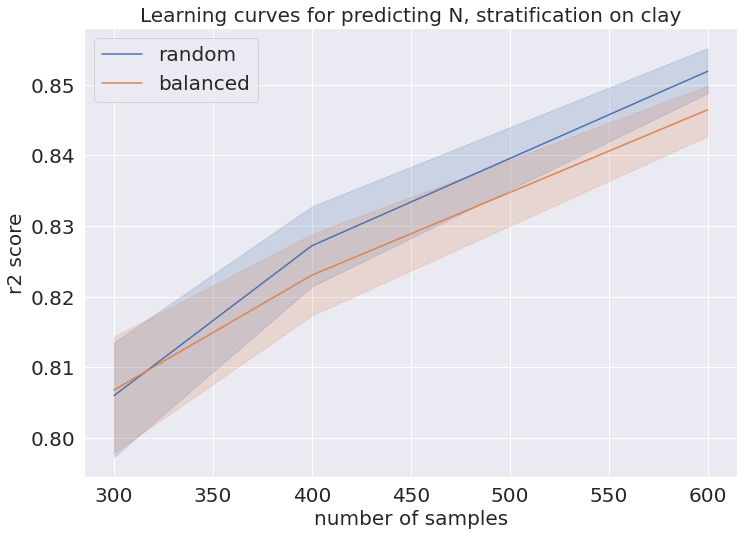

In [18]:
N_clay = get_clean_analyte_df(["N", "clay"], size="all", target="N")
sns.set_theme()
sns.color_palette("deep") # try dark
seeds = range(SEED, SEED+10)
plot_lc_comparison(N_clay, "N", stratify="clay", adverse=False, stable=True, manual_sizes=[300, 400, 600], seed=seeds)


======= random stratification =======
getting cached cache/prod/get_lc_geo/df:shape:(41297, 1768)-N#seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:300,400,600#9bebec9a82b61a156827e8efe3f9e6b7d2a42219309c19e9e0053991a6fd2639

======= balanced stratification =======
getting cached cache/prod/get_lc_geo/df:shape:(41297, 1768)-N#stratify:clay-seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:300,400,600#c2d7f6a17102520feff6da26fadcf842eecc84538301cc8c08aa63f5a4577c79


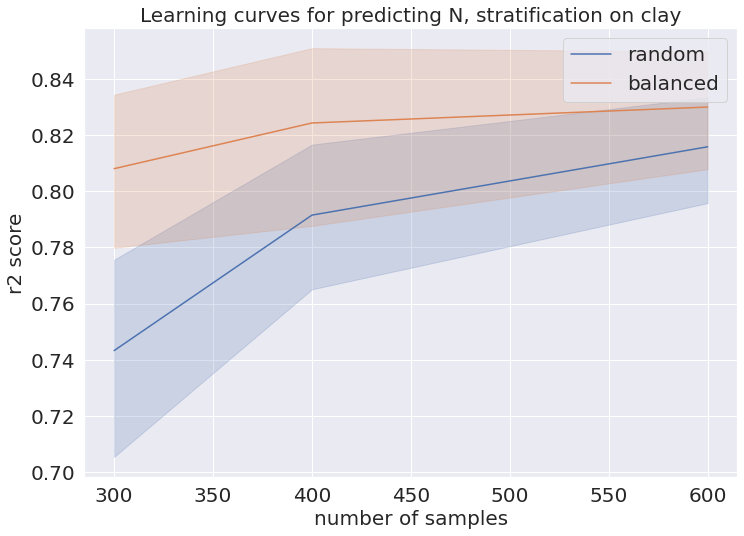

In [19]:
plot_lc_comparison(N_clay, "N", stratify="clay", adverse=False, stable=False, manual_sizes=[300, 400, 600], seed=seeds)

getting cached cache/prod/get_clean_analyte_df/C,water#size:all-target:C#7ca09bbfcafa41a14852720c610cc0ccc91f69a6abe3cd8de87504ba5ac467d6

======= random stratification =======
getting cached cache/prod/get_lc_geo/df:shape:(36702, 1768)-C#seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:100,120,150,170,200,250,300,400,600,800#219ee7b9362f4e2e18f0ce41e92948e6f323958d16fc0cf58ae3a7ed79c1fa1b

======= balanced stratification =======
getting cached cache/prod/get_lc_geo/df:shape:(36702, 1768)-C#stratify:water-seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:100,120,150,170,200,250,300,400,600,800#c80d8a299d58e5a11101fdf1134d4ef3924f90178157e2cb8f26351a4bfd7e20


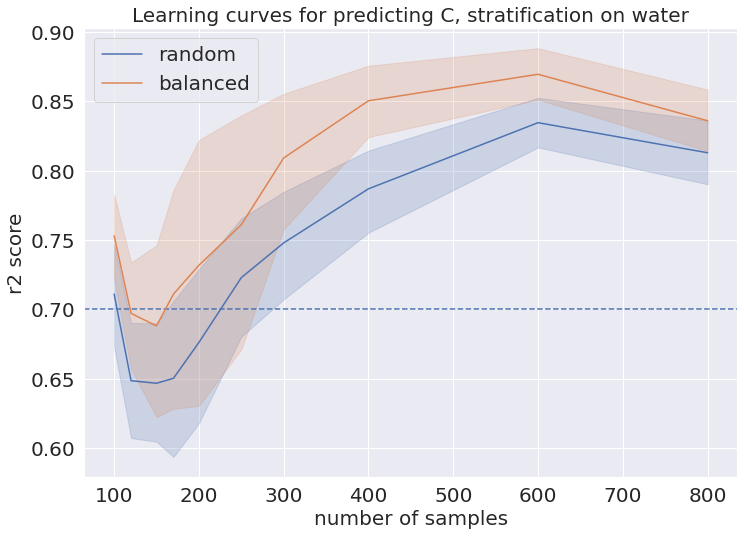

In [20]:
C_water = get_clean_analyte_df(["C", "water"], size="all", target="C")
seeds = range(SEED, SEED+10)



clay2 = MultiStrat({"clay":2})
water2 = MultiStrat({"water":2})
ph2 = MultiStrat({"pH":2})


plot_lc_comparison(C_water, "C", stratify="water", adverse=False,
                   manual_sizes=[100, 120, 150, 170, 200, 250, 300, 400, 600, 800], smooth=5,
                   seed=seeds, hline=True)


======= random stratification =======
getting cached cache/prod/get_lc_geo/df:shape:(36702, 1768)-C#seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:100,120,150,170,200,250,300,400,600,800#219ee7b9362f4e2e18f0ce41e92948e6f323958d16fc0cf58ae3a7ed79c1fa1b

======= balanced stratification =======
getting cached cache/prod/get_lc_geo/df:shape:(36702, 1768)-C#stratify:{'water': 2}-seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:100,120,150,170,200,250,300,400,600,800#f090705e622c5fcd19398f37a0728ca69ed4b067e2ce97b8001419df36103719


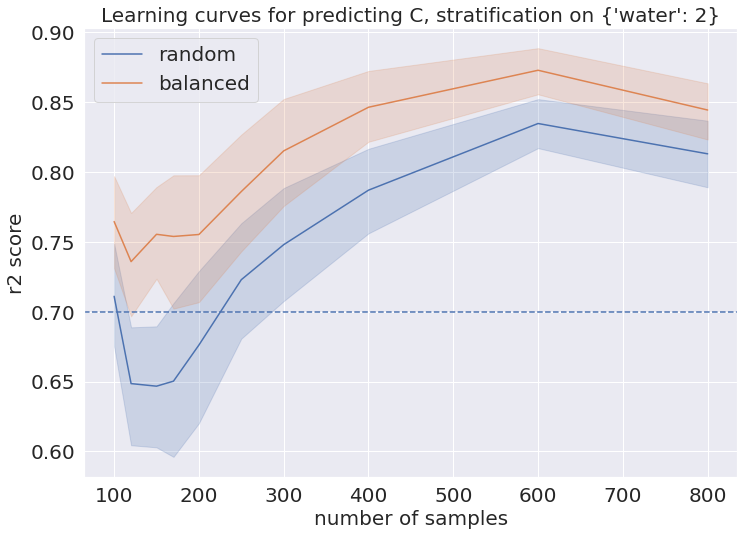

In [21]:
plot_lc_comparison(C_water, "C", stratify=water2, adverse=False,
                   manual_sizes=[100, 120, 150, 170, 200, 250, 300, 400, 600, 800], smooth=5,
                   seed=seeds, hline=True)

getting cached cache/prod/get_clean_analyte_df/N,clay#target:N-size:all#791890e7a7ef341912ef0a61ac8bdacfb1f90672f70ceb98677e307637151b92

======= random stratification =======
getting cached cache/prod/get_lc_geo/df:shape:(41297, 1768)-N#seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:100,120,150,170,200,250,300,400,600,800#8d455dca4a051a8ba8815f164a75078640717838e83eb53ede5bec5e01c28f4c

======= balanced stratification =======
getting cached cache/prod/get_lc_geo/df:shape:(41297, 1768)-N#stratify:clay-seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:100,120,150,170,200,250,300,400,600,800#0045703f419b2618d6cfbc6c502d4378b2d850e53c496e8d904cb31c81fb2a9e


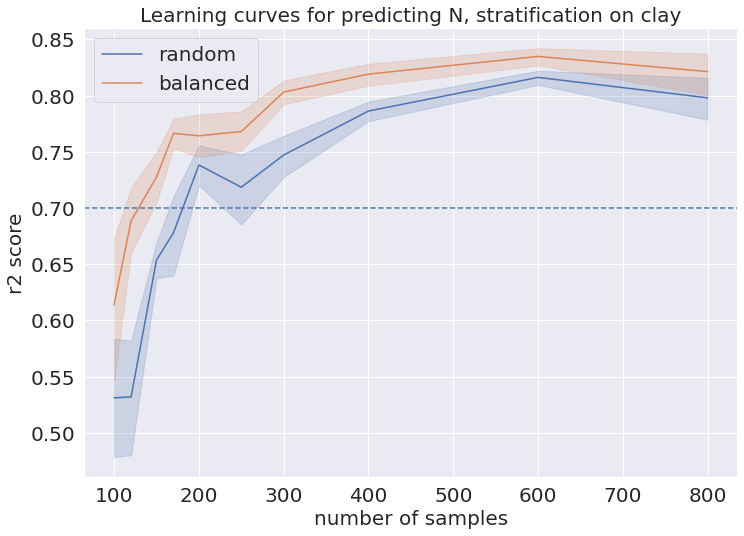

In [22]:
N_clay = get_clean_analyte_df(["N", "clay"], target="N", size="all")


plot_lc_comparison(N_clay, "N", stratify="clay", adverse=False,
                   manual_sizes=[100, 120, 150, 170, 200, 250, 300, 400, 600, 800], smooth=2,
                   seed=seeds, hline=True)


======= random stratification =======
getting cached cache/prod/get_lc_geo/df:shape:(41297, 1768)-N#seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:100,120,150,170,200,250,300,400,600,800#8d455dca4a051a8ba8815f164a75078640717838e83eb53ede5bec5e01c28f4c

======= balanced stratification =======
getting cached cache/prod/get_lc_geo/df:shape:(41297, 1768)-N#stratify:{'clay': 2}-seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:100,120,150,170,200,250,300,400,600,800#580a3dce28620ff83264ada151599af98cd43bc0037fa1acc28c4dfa77b5c28e


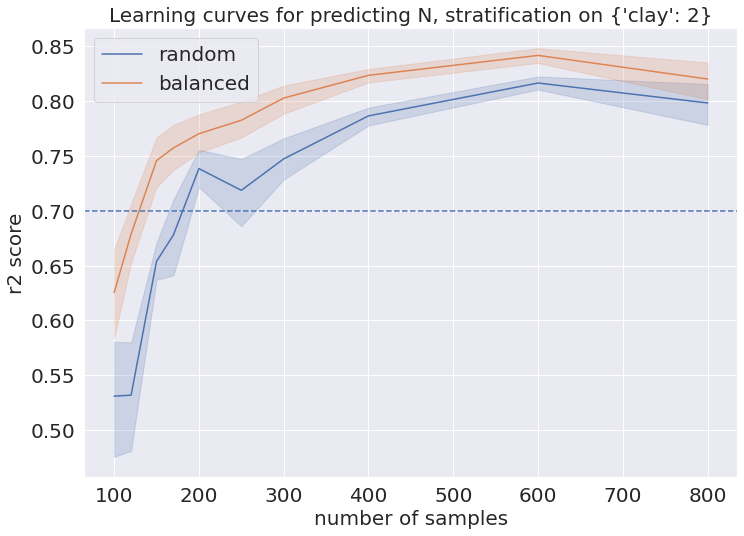

In [23]:
plot_lc_comparison(N_clay, "N", stratify=clay2, adverse=False,
                   manual_sizes=[100, 120, 150, 170, 200, 250, 300, 400, 600, 800], smooth=2,
                   seed=seeds, hline=True)

getting cached cache/prod/get_clean_analyte_df/N,water#target:N-size:all#bf29f2bda001363fd161e5f1f725cb6fa1a041d613117d7946c0de54746d6a81

======= random stratification =======
getting cached cache/prod/get_lc_geo/df:shape:(32456, 1768)-N#seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:100,120,150,170,200,250,300,400,600,800#40fa4d3adcef00b9b48cffe5b5bc39b990266ea2e63a2201cce9b0a461f0faf7

======= balanced stratification =======
getting cached cache/prod/get_lc_geo/df:shape:(32456, 1768)-N#stratify:water-seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:100,120,150,170,200,250,300,400,600,800#37a91091dae30b408148dce8d9dcb42a2de2c8f1bd77cb405abf3cb33a08b387


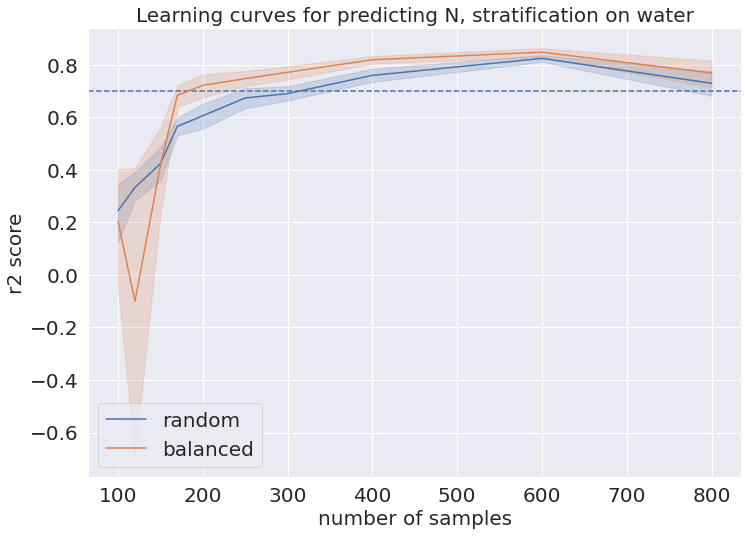

In [24]:
N_water = get_clean_analyte_df(["N", "water"], target="N", size="all")


plot_lc_comparison(N_water, "N", stratify="water", adverse=False,
                   manual_sizes=[100, 120, 150, 170, 200, 250, 300, 400, 600, 800], smooth=2,
                   seed=seeds, hline=True)


======= random stratification =======
getting cached cache/prod/get_lc_geo/df:shape:(32456, 1768)-N#seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:100,120,150,170,200,250,300,400,600,800#40fa4d3adcef00b9b48cffe5b5bc39b990266ea2e63a2201cce9b0a461f0faf7

======= balanced stratification =======
getting cached cache/prod/get_lc_geo/df:shape:(32456, 1768)-N#stratify:{'water': 2}-seeds:range(667788, 667798)-min_size:0.03-rate:0.3-manual_sizes:100,120,150,170,200,250,300,400,600,800#d96f449c1a8f6bea750456a112b2c31bc9ebeaef75d77afe7cca477b39fbd6f9


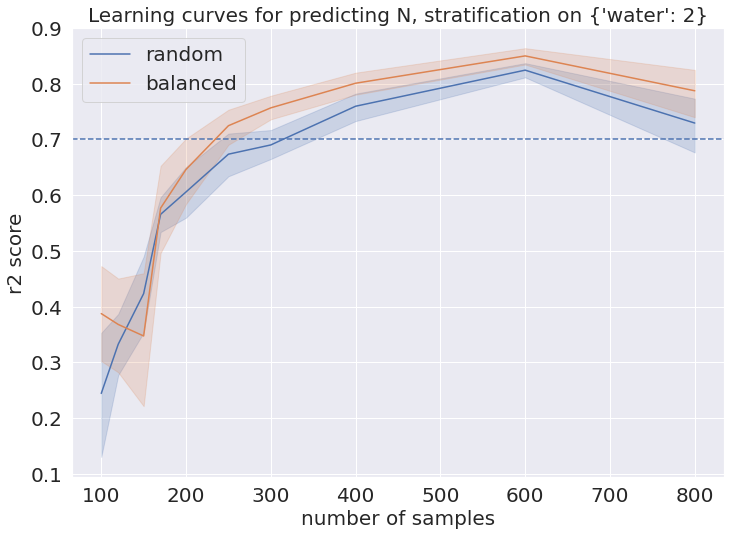

In [25]:
plot_lc_comparison(N_water, "N", stratify=water2, adverse=False,
                   manual_sizes=[100, 120, 150, 170, 200, 250, 300, 400, 600, 800], smooth=2,
                   seed=seeds, hline=True)

# Model partitioning 
## (needs updating with using cross validation)

In [26]:
# TODO: try plsr here

def score_partitioned_model(df, analyte, partition_on, threshold, model_factory=xtrees_factory, seed=SEED):
    low_df, high_df = df[df[partition_on] <= threshold], df[df[partition_on] > threshold]
    for subset, desc in zip([low_df, high_df], ["lower than", "higher than"]):
        score = cv_score(subset, analyte, random_state=seed, model_factory=model_factory).mean()
        print(f'score for predicting {analyte} when {partition_on} is {desc} {threshold}: {score}')
    score = cv_score(df, analyte, random_state=seed, model_factory=model_factory).mean()
    print(f'score for predicting {analyte} on all data: {score}')


In [27]:
# score_partitioned_model(clay_df, analyte="water", partition_on="clay", threshold=20)

# is this only because there is less data to train on?

In [28]:
def simulate_model_partitioning_sizes(df, analyte, partition_on, threshold, stratify_f=None, model_factory=xtrees_factory):
    low_size = (df[partition_on] <= threshold).sum()
    if stratify_f:
        stratify = stratify_f(df)
    else:
        stratify = None
    low_df, high_df = train_test_split(df, train_size=low_size, stratify=stratify, random_state=SEED)
    if stratify_f:
        high_st, low_st = stratify_f(high_df), stratify_f(low_df)
    else:
        high_st, low_st = None, None
    high_data, low_data = get_model_data(high_df, analyte, high_st), get_model_data(low_df, analyte, low_st)
    for data, desc in zip([high_data, low_data], ["lower than", "higher than"]):
        score = score_model(model_factory(), *data)
        print(f'score for predicting {analyte} when dataset sizes are the same '\
            f'as when partitioning according to {partition_on} being {desc} {threshold}: {score}')


In [29]:
# simulate_model_partitioning_sizes(clay_df, analyte="water", partition_on="clay", threshold=20)

# How about perfect stratification?

In [30]:
def binary_threshold_stratify_f(analyte, threshold):
    def _stratify_f(df):
        return df[analyte] <= threshold
    return _stratify_f

    
# np.random.seed(SEED) # why doesn't passing random state work?? (this works thank god)
# random.seed(SEED)
# simulate_model_partitioning_sizes(clay_df, analyte="water", partition_on="clay", threshold=20, stratify_f=binary_threshold_stratify_f("clay", 20))


# Geographically small

In [31]:
# N = get_clean_analyte_df("N", size=1)
# N_geo =  get_clean_analyte_df(["N", "location"], size=1)

In [32]:
# small_N = N.sort_values("smp_id").iloc[:1000]
# cv_score(small_N, "N")


In [33]:
# sns.scatterplot(data=N_geo, x="lat_site", y="long_site")

# delta = 1
# lat_interval = [40 - delta, 40 + delta]
# long_interval = [-100 - delta, -100 + delta]

# def cut_interval(df, col, i):
#     return df[(df[col] >= i[0]) & (df[col] <= i[1])]


# small_N_lat = cut_interval(N_geo, "lat_site", lat_interval)
# small_N_geo = cut_interval(small_N_lat, "long_site", long_interval)


# print(len(small_N_geo.index))
# cv_score(small_N_geo, "N")


# inverstigate phosphorus on easy usda

In [34]:
# cv_score(usda.sample(1000, random_state=SEED), "phosphorus")

In [35]:
# cv_score(usda.iloc[:500], "phosphorus")

In [36]:
# df = transform_specs(usda_raw, funcy.compose(remove_baseline, snv))

In [37]:
# cv_score(df.iloc[:500], "phosphorus")

In [38]:
# cv_score(df.iloc[:500], "phosphorus", model_factory=plsr_factory)

In [39]:
# cv_score(usda.sample(frac=0.05, random_state=SEED), "phosphorus").mean()

In [40]:
# cv_score(usda.sample(frac=0.1, random_state=SEED), "phosphorus").mean()

In [41]:
# cv_score(clay_df.sample(frac=0.1, random_state=SEED), "phosphorus")

In [42]:
# cv_score(clay_df.sample(frac=0.05, random_state=SEED), "phosphorus")

In [43]:
# p2 = get_clean_analyte_df("P2", size=1000)
# cv_score(p2.sample(frac=0.5, random_state=SEED), "P2")

In [44]:
# p6 = get_clean_analyte_df("P6", size=1000)
# cv_score(p6.sample(frac=0.5, random_state=SEED), "P6")

# identifying important freqs

In [45]:
def important_freqs(fi, n_germs=100, delta=2):
    germs = np.argsort(fi)[-n_germs:]
    germs_shifted = [germs + d for d in range(-delta, delta+1)]
    indexes = np.unique(np.concatenate(germs_shifted))
    all_freqs = spec_cols_names(usda)
    indexes = indexes[(indexes >= 0) & (indexes < len(all_freqs))]
    
    return all_freqs[indexes]
    
@cached("train_model")
def train_model(df, analyte, model_factory=xtrees_factory):
    model = model_factory()
    X = spec_cols(df)
    y = df[analyte]
    print(f"training on full data: {len(df.index)}...")
    model.fit(X, y)
    return model


def test_model(model, df, analyte):
    X = spec_cols(df)
    y = df[analyte]
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

In [46]:
def plot_subfreqs_comparison(df, analyte, seed=SEED, model_factory=xtrees_factory, stratify=None, nb_seeds=2, delta=1):
    if stratify is not None:
        assert isinstance(stratify, str), "multi strat not supported here"
    train_df = get_clean_analyte_df(analyte, seed=2*seed+1423423, target=analyte)
    model = train_model(train_df, analyte, model_factory)
    feats = model.feature_importances_
    germ_nbs = [30, 50, 100, 2000]
    subfreqs = [important_freqs(feats, n_germs=n_germs, delta=delta) for n_germs in germ_nbs]
    subdfs = [df[fs].copy() for fs in subfreqs]
    for subdf in subdfs:
        subdf[analyte] = df[analyte]
        if stratify:
            subdf[stratify] = df[stratify]
    seeds = [seed + i for i in range(nb_seeds)]
    lcs = [get_lc_geo(subdf, analyte, stratify=stratify, seeds=seeds) for subdf in subdfs]
    plot_lcs(lcs, list(map(len, subfreqs)))
    

    plt.title(f"Subseting frequencies for {pretty_analyte(analyte)}", fontsize=20)
    

    plt.legend(prop={"size":20},title="number of features", fancybox=True)


In [47]:
def report_subfreqs(analyte, seeds, size, stratify=None):
    analytes = [analyte] 
    if stratify is not None:
        analytes.append(stratify)
        
    df = get_clean_analyte_df(analytes, size=5000, target=analyte)
    if stratify is not None:
        assert isinstance(stratify, str), "multi strat not supported here"
    train_df = get_clean_analyte_df(analyte, seed=2*SEED+1423423, target=analyte)
    model = train_model(train_df, analyte)
    feats = model.feature_importances_
    germ_nbs = [30, 50, 100, 2000]
    subfreqs = [important_freqs(feats, n_germs=n_germs, delta=1) for n_germs in germ_nbs]
    subdfs = [df[fs].copy() for fs in subfreqs]
    for subdf in subdfs:
        subdf[analyte] = df[analyte]
        if stratify:
            subdf[stratify] = df[stratify]
            
    all_scores = []
    for seed in seeds:
        print(f"evaluating with seed {seed}...")
        for subdf, germs, feats in zip(subdfs, germ_nbs, subfreqs):
            data = subdf.sample(n=size, random_state=seed)
            scores = cv_score(data, analyte, stratify=stratify, random_state=seed)
            all_scores += [(s, germs, len(feats)) for s in scores]
            
    return DF(all_scores, columns=["score", "germs", "feats"]).groupby(["germs", "feats"]).mean()

In [48]:
seeds = range(SEED, SEED+10)

report_subfreqs("N", seeds=seeds, size=100)

getting cached cache/prod/get_clean_analyte_df/N#size:5000-target:N#7b02a54ad9a62169f63694f59287bc2ed1f4da03c6d0d80b09570b36af595e3b
getting cached cache/prod/get_clean_analyte_df/N#seed:2758999-target:N#ee48f110c3f71e30d77e4f71cbe74fb8ff6d88fa7fd00bce7e1967f74278c1db
getting cached cache/prod/train_model/df:shape:(5000, 1767)-N##27623e9bb0476c93627abc2c6108a3b65b9a7edf18079520100f9808fb935e29
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(100, 37)-N#stratify:None-random_state:667788#7b4616e5e48ca13a1e124bf71a833431c59f3151e1f4d7a58a1b714a549f5b13
getting cached cache/prod/cv_score/df:shape:(100, 63)-N#stratify:None-random_state:667788#09d24a5b7c368ac7c24953f258975d7da19c2add393d88a06e85ef95f4614719
getting cached cache/prod/cv_score/df:shape:(100, 126)-N#stratify:None-random_state:667788#c5b207b021eccf61bf73a2542c29e9209f0623dcb6d3c2b606dce3ab14ac71b3
getting cached cache/prod/cv_score/df:shape:(100, 1766)-N#stratify:None-random_state:667788#fb65664f90477f

,,score
germs,feats,
30,36,0.713153
50,62,0.779893
100,125,0.785657
2000,1765,0.661658


In [49]:
report_subfreqs("N", seeds=seeds, size=50)

getting cached cache/prod/get_clean_analyte_df/N#size:5000-target:N#7b02a54ad9a62169f63694f59287bc2ed1f4da03c6d0d80b09570b36af595e3b
getting cached cache/prod/get_clean_analyte_df/N#seed:2758999-target:N#ee48f110c3f71e30d77e4f71cbe74fb8ff6d88fa7fd00bce7e1967f74278c1db
getting cached cache/prod/train_model/df:shape:(5000, 1767)-N##27623e9bb0476c93627abc2c6108a3b65b9a7edf18079520100f9808fb935e29
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(50, 37)-N#stratify:None-random_state:667788#ed6b4fd08f9badb01385c9bb501e841f93d40957ff61b4bb1e130652ed3155fd
getting cached cache/prod/cv_score/df:shape:(50, 63)-N#stratify:None-random_state:667788#b9365e836fb07742452dc290a761063edd05a48d849b786126d38d0c98ab6416
getting cached cache/prod/cv_score/df:shape:(50, 126)-N#stratify:None-random_state:667788#4e49f2291ac809d8214d79273a2f7ec274e0b96839393661359be5124b93c7f2
getting cached cache/prod/cv_score/df:shape:(50, 1766)-N#stratify:None-random_state:667788#6dc3ed2dbcf7b357d8

,,score
germs,feats,
30,36,0.672705
50,62,0.742974
100,125,0.695548
2000,1765,0.243989


In [50]:
report_subfreqs("N", seeds=seeds, size=400)

getting cached cache/prod/get_clean_analyte_df/N#size:5000-target:N#7b02a54ad9a62169f63694f59287bc2ed1f4da03c6d0d80b09570b36af595e3b
getting cached cache/prod/get_clean_analyte_df/N#seed:2758999-target:N#ee48f110c3f71e30d77e4f71cbe74fb8ff6d88fa7fd00bce7e1967f74278c1db
getting cached cache/prod/train_model/df:shape:(5000, 1767)-N##27623e9bb0476c93627abc2c6108a3b65b9a7edf18079520100f9808fb935e29
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(400, 37)-N#stratify:None-random_state:667788#8b9abe4db0211ac0701a1f420bb461c40e2eaba793d11dd75b13baa61d6a907d
getting cached cache/prod/cv_score/df:shape:(400, 63)-N#stratify:None-random_state:667788#29b1a46a52590a8d0db35fcc9a8a02428ef9cefc55d66263adb80beb04dbc99e
getting cached cache/prod/cv_score/df:shape:(400, 126)-N#stratify:None-random_state:667788#437156611ee406700e717bfec65d559ea8189557587e31fd46373b1dde577ab7
getting cached cache/prod/cv_score/df:shape:(400, 1766)-N#stratify:None-random_state:667788#9e319683fdac15

,,score
germs,feats,
30,36,0.862390
50,62,0.876154
100,125,0.891979
2000,1765,0.864292


In [51]:
report_subfreqs("N", seeds=seeds, size=1000)

getting cached cache/prod/get_clean_analyte_df/N#size:5000-target:N#7b02a54ad9a62169f63694f59287bc2ed1f4da03c6d0d80b09570b36af595e3b
getting cached cache/prod/get_clean_analyte_df/N#seed:2758999-target:N#ee48f110c3f71e30d77e4f71cbe74fb8ff6d88fa7fd00bce7e1967f74278c1db
getting cached cache/prod/train_model/df:shape:(5000, 1767)-N##27623e9bb0476c93627abc2c6108a3b65b9a7edf18079520100f9808fb935e29
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(1000, 37)-N#stratify:None-random_state:667788#13f1546d37f67b0efca6dff3cf4e315aa8c155470e701f45ea91a0c39040d1ce
getting cached cache/prod/cv_score/df:shape:(1000, 63)-N#stratify:None-random_state:667788#c3c4aefdd6e4b4cfd6aff1fe11ed31a0b115c493bfa637dee4e5e21a05a5b758
getting cached cache/prod/cv_score/df:shape:(1000, 126)-N#stratify:None-random_state:667788#453b2dd2099b21751d60818fe85120f3d82af5963521e9fc80e33edf82db2239
getting cached cache/prod/cv_score/df:shape:(1000, 1766)-N#stratify:None-random_state:667788#4420d0dcea

,,score
germs,feats,
30,36,0.885017
50,62,0.904295
100,125,0.913776
2000,1765,0.908412


In [52]:
report_subfreqs("N", seeds=seeds, size=3000)

getting cached cache/prod/get_clean_analyte_df/N#size:5000-target:N#7b02a54ad9a62169f63694f59287bc2ed1f4da03c6d0d80b09570b36af595e3b
getting cached cache/prod/get_clean_analyte_df/N#seed:2758999-target:N#ee48f110c3f71e30d77e4f71cbe74fb8ff6d88fa7fd00bce7e1967f74278c1db
getting cached cache/prod/train_model/df:shape:(5000, 1767)-N##27623e9bb0476c93627abc2c6108a3b65b9a7edf18079520100f9808fb935e29
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(3000, 37)-N#stratify:None-random_state:667788#4526e7725e8455ac0063f7faec164a77616d92ad28f194b714bc33255c172503
getting cached cache/prod/cv_score/df:shape:(3000, 63)-N#stratify:None-random_state:667788#8684b844acdbc3708070d433797e1be3729be908bcbfe31ffda3c481e29da65f
getting cached cache/prod/cv_score/df:shape:(3000, 126)-N#stratify:None-random_state:667788#bf653404ef3f86d2a85eeed3b826bcfb1fa603827a4003223b0d7c718c1a39a5
getting cached cache/prod/cv_score/df:shape:(3000, 1766)-N#stratify:None-random_state:667788#c585840a78

,,score
germs,feats,
30,36,0.898651
50,62,0.915450
100,125,0.926289
2000,1765,0.925614


In [53]:
report_subfreqs("C", seeds=seeds, size=50)

getting cached cache/prod/get_clean_analyte_df/C#size:5000-target:C#f443ee6d428e16c97e1b3888cd8f8ec9cf2386c596f5fa0eca9cb40e02964589
getting cached cache/prod/get_clean_analyte_df/C#seed:2758999-target:C#f917c5c4fe70ff90bc47f4c29c669521f5d8909a25af37e39baf8aefae17656d
getting cached cache/prod/train_model/df:shape:(5000, 1767)-C##654cf6ef198e1ed16fb879c34b969abcacec2d94d75087ebb4d6a97210f762d8
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(50, 37)-C#stratify:None-random_state:667788#ce52f207682eb8826afc37cff4aec5b4b266079ae586b2b2838cd93229a531f8
getting cached cache/prod/cv_score/df:shape:(50, 61)-C#stratify:None-random_state:667788#4163808d055b28e0bf2dda80b502390b996115fa314a0bbcf249c7519063398d
getting cached cache/prod/cv_score/df:shape:(50, 125)-C#stratify:None-random_state:667788#92d529f38f6b8f66473d7e68c69f49866a3f9a95b7123c066b9ef1ec88170667
getting cached cache/prod/cv_score/df:shape:(50, 1766)-C#stratify:None-random_state:667788#661365f4b98b12c6d5

,,score
germs,feats,
30,36,0.451857
50,60,-0.854815
100,124,-1.270923
2000,1765,-0.190357


In [54]:
report_subfreqs("C", seeds=seeds, size=100)

getting cached cache/prod/get_clean_analyte_df/C#size:5000-target:C#f443ee6d428e16c97e1b3888cd8f8ec9cf2386c596f5fa0eca9cb40e02964589
getting cached cache/prod/get_clean_analyte_df/C#seed:2758999-target:C#f917c5c4fe70ff90bc47f4c29c669521f5d8909a25af37e39baf8aefae17656d
getting cached cache/prod/train_model/df:shape:(5000, 1767)-C##654cf6ef198e1ed16fb879c34b969abcacec2d94d75087ebb4d6a97210f762d8
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(100, 37)-C#stratify:None-random_state:667788#02877e9b6e0ebe2e5e19c24a89988aae50659b78a922e255754868ee0acfa2b8
getting cached cache/prod/cv_score/df:shape:(100, 61)-C#stratify:None-random_state:667788#53c7d28df84cc33f6725f08a4872e06aa5477c2a6b4f0009c078db4be0e15c39
getting cached cache/prod/cv_score/df:shape:(100, 125)-C#stratify:None-random_state:667788#17b64b08d67dd831b151f25dbd1d84cdbc9c07d9ea435946882e565f7d69befd
getting cached cache/prod/cv_score/df:shape:(100, 1766)-C#stratify:None-random_state:667788#3e22656be7ce5f

,,score
germs,feats,
30,36,0.869734
50,60,0.895084
100,124,0.882235
2000,1765,0.838951


In [55]:
report_subfreqs("C", seeds=seeds, size=400)

getting cached cache/prod/get_clean_analyte_df/C#size:5000-target:C#f443ee6d428e16c97e1b3888cd8f8ec9cf2386c596f5fa0eca9cb40e02964589
getting cached cache/prod/get_clean_analyte_df/C#seed:2758999-target:C#f917c5c4fe70ff90bc47f4c29c669521f5d8909a25af37e39baf8aefae17656d
getting cached cache/prod/train_model/df:shape:(5000, 1767)-C##654cf6ef198e1ed16fb879c34b969abcacec2d94d75087ebb4d6a97210f762d8
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(400, 37)-C#stratify:None-random_state:667788#758b46a98cdfaa4262ee091d1035cdccb9eaa105e9295c5938c07d549b7b55cb
getting cached cache/prod/cv_score/df:shape:(400, 61)-C#stratify:None-random_state:667788#7a434905c79d131cbd3e8894fe37f90929b3dba7d6076e1a856939d27c9aad14
getting cached cache/prod/cv_score/df:shape:(400, 125)-C#stratify:None-random_state:667788#a19d0283f8f47af67c2d5b9bc0f3820e452b3d6da54d402338fae4b3f40c3628
getting cached cache/prod/cv_score/df:shape:(400, 1766)-C#stratify:None-random_state:667788#b5139d48bdf9ff

,,score
germs,feats,
30,36,0.946174
50,60,0.955841
100,124,0.963008
2000,1765,0.959405


In [56]:
report_subfreqs("C", seeds=seeds, size=1000)

getting cached cache/prod/get_clean_analyte_df/C#size:5000-target:C#f443ee6d428e16c97e1b3888cd8f8ec9cf2386c596f5fa0eca9cb40e02964589
getting cached cache/prod/get_clean_analyte_df/C#seed:2758999-target:C#f917c5c4fe70ff90bc47f4c29c669521f5d8909a25af37e39baf8aefae17656d
getting cached cache/prod/train_model/df:shape:(5000, 1767)-C##654cf6ef198e1ed16fb879c34b969abcacec2d94d75087ebb4d6a97210f762d8
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(1000, 37)-C#stratify:None-random_state:667788#1889bc430320bf73c943b5c320add13223f40d339cb289216006d9c970d753dd
getting cached cache/prod/cv_score/df:shape:(1000, 61)-C#stratify:None-random_state:667788#88f0f17bb1d9834f7ebef11732f68eedb5154868d077b5024ae895d78a088578
getting cached cache/prod/cv_score/df:shape:(1000, 125)-C#stratify:None-random_state:667788#22d46d38793799619616d0d4009600749e02ee8aa62c0d6b5b4eb45e94c0d9e9
getting cached cache/prod/cv_score/df:shape:(1000, 1766)-C#stratify:None-random_state:667788#c8ce6eb8c5

,,score
germs,feats,
30,36,0.963836
50,60,0.968053
100,124,0.976402
2000,1765,0.975951


In [57]:
report_subfreqs("C", seeds=seeds, size=3000)

getting cached cache/prod/get_clean_analyte_df/C#size:5000-target:C#f443ee6d428e16c97e1b3888cd8f8ec9cf2386c596f5fa0eca9cb40e02964589
getting cached cache/prod/get_clean_analyte_df/C#seed:2758999-target:C#f917c5c4fe70ff90bc47f4c29c669521f5d8909a25af37e39baf8aefae17656d
getting cached cache/prod/train_model/df:shape:(5000, 1767)-C##654cf6ef198e1ed16fb879c34b969abcacec2d94d75087ebb4d6a97210f762d8
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(3000, 37)-C#stratify:None-random_state:667788#ad197ca1e1ccc30260bf88efd90b7b9f5c76f7491258336051f29275a8b9f21b
getting cached cache/prod/cv_score/df:shape:(3000, 61)-C#stratify:None-random_state:667788#af3b0117b2b167b92909872c2645f5d54bfd55a69333cb9f455db6ce953c7851
getting cached cache/prod/cv_score/df:shape:(3000, 125)-C#stratify:None-random_state:667788#f68bf1cbeb1e7bc27cb70ac1c635750427c70346208e96b8c6c5ce6382fb1b39
getting cached cache/prod/cv_score/df:shape:(3000, 1766)-C#stratify:None-random_state:667788#4c9d494e12

,,score
germs,feats,
30,36,0.970880
50,60,0.973432
100,124,0.980450
2000,1765,0.981520


getting cached cache/prod/get_clean_analyte_df/N,clay,water#target:N#64626f0d24a2cbdad8f5bc0ef580df568a0ef2df5edc9111a382d7e10b0a4bd9
getting cached cache/prod/get_clean_analyte_df/N#seed:2758999-target:N#ee48f110c3f71e30d77e4f71cbe74fb8ff6d88fa7fd00bce7e1967f74278c1db
getting cached cache/prod/train_model/df:shape:(5000, 1767)-N-xtrees_factory##008d5c95854a4c89c626049fca20a946623cfe5b6e825032cbfb0aa1dd23217d
getting cached cache/prod/get_lc_geo/df:shape:(5000, 38)-N#stratify:clay-seeds:667788,667789#c4e42dbb6e784bae5caf337fa4518b16da504841054a2b9beb8712431574a553
getting cached cache/prod/get_lc_geo/df:shape:(5000, 64)-N#stratify:clay-seeds:667788,667789#64d741803ae602f17a4621f221a202f8838dd8ac5726047aa87c7f048ff5f90c
getting cached cache/prod/get_lc_geo/df:shape:(5000, 127)-N#stratify:clay-seeds:667788,667789#bd4f8aa8cb9908ab8112ecc0dad6ed28bf9c0c78dcd3ea486a47536eb1ee3e98
getting cached cache/prod/get_lc_geo/df:shape:(5000, 1767)-N#stratify:clay-seeds:667788,667789#27b3cbd9b954a5e03

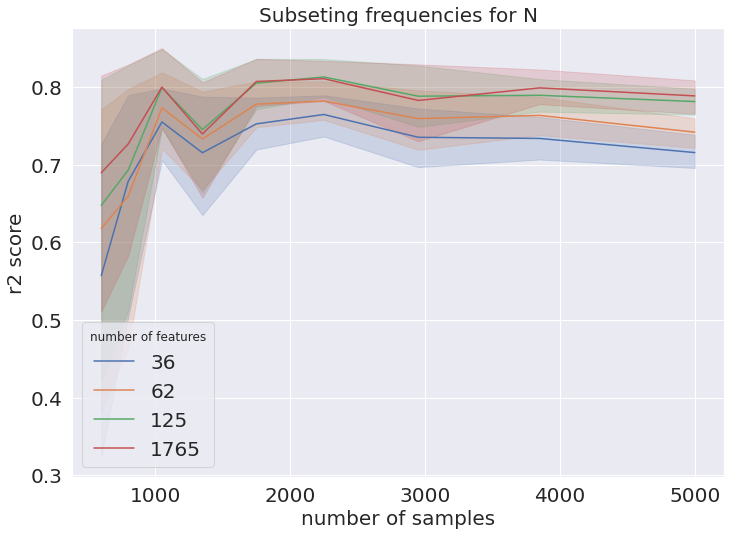

In [58]:
N_clay_water = get_clean_analyte_df(["N", "clay", "water"], target="N")

plot_subfreqs_comparison(N_clay_water, "N", stratify="clay")

getting cached cache/prod/get_clean_analyte_df/N#seed:2758999-target:N#ee48f110c3f71e30d77e4f71cbe74fb8ff6d88fa7fd00bce7e1967f74278c1db
getting cached cache/prod/train_model/df:shape:(5000, 1767)-N-xtrees_factory##008d5c95854a4c89c626049fca20a946623cfe5b6e825032cbfb0aa1dd23217d
getting cached cache/prod/get_lc_geo/df:shape:(5000, 37)-N#stratify:N-seeds:667788,667789#d6bf10a4076c8c70c97b9026a11232fa6a35ca20490eb53622bf3243772232bf
getting cached cache/prod/get_lc_geo/df:shape:(5000, 63)-N#stratify:N-seeds:667788,667789#ace2a94313f9b18d8c0dbfa7357030b40bd30a5ef4afbe83f5cd1687fc670e99
getting cached cache/prod/get_lc_geo/df:shape:(5000, 126)-N#stratify:N-seeds:667788,667789#0420da51c45b17e8a19cb29c6a024a737b0dce2ef81b2e15b5a0cc168290382b
getting cached cache/prod/get_lc_geo/df:shape:(5000, 1766)-N#stratify:N-seeds:667788,667789#46cd4353a35a94625c5895e19d157c4b4fcc656c1434b1035902ff9fd54be855


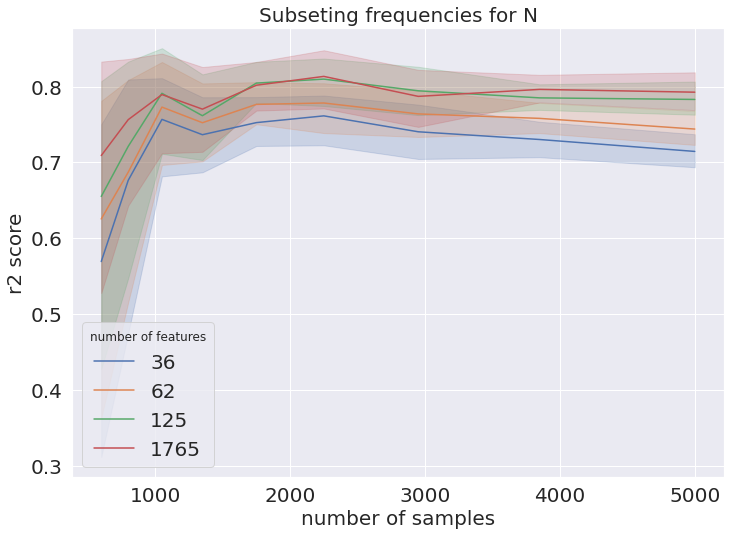

In [59]:
plot_subfreqs_comparison(N_clay_water, "N", stratify="N")

getting cached cache/prod/get_clean_analyte_df/N#target:N#15c841dff8407a197a8be456d43283d973c0ba690724b24da5e5d0d6dbc70423
getting cached cache/prod/get_clean_analyte_df/N#seed:2758999-target:N#ee48f110c3f71e30d77e4f71cbe74fb8ff6d88fa7fd00bce7e1967f74278c1db
getting cached cache/prod/train_model/df:shape:(5000, 1767)-N-xtrees_factory##008d5c95854a4c89c626049fca20a946623cfe5b6e825032cbfb0aa1dd23217d
getting cached cache/prod/get_lc_geo/df:shape:(5000, 37)-N#stratify:N-seeds:667788,667789#100d6e0257de40dfcbb0ea04f311f88a0f36d8b90b3c15e3a71bda256d0cedd3
getting cached cache/prod/get_lc_geo/df:shape:(5000, 63)-N#stratify:N-seeds:667788,667789#ae17db4c9ddae11d40093d1afeddf063224745f9497d019f60c35113bcf97372
getting cached cache/prod/get_lc_geo/df:shape:(5000, 126)-N#stratify:N-seeds:667788,667789#799c11bbf8623e37e2f70724f5b39cdf0bb6e670a65229c53e7a342f16401e5c
getting cached cache/prod/get_lc_geo/df:shape:(5000, 1766)-N#stratify:N-seeds:667788,667789#8d5abc1ca789c3c1fed3e0c1638a925ae4fdd8df

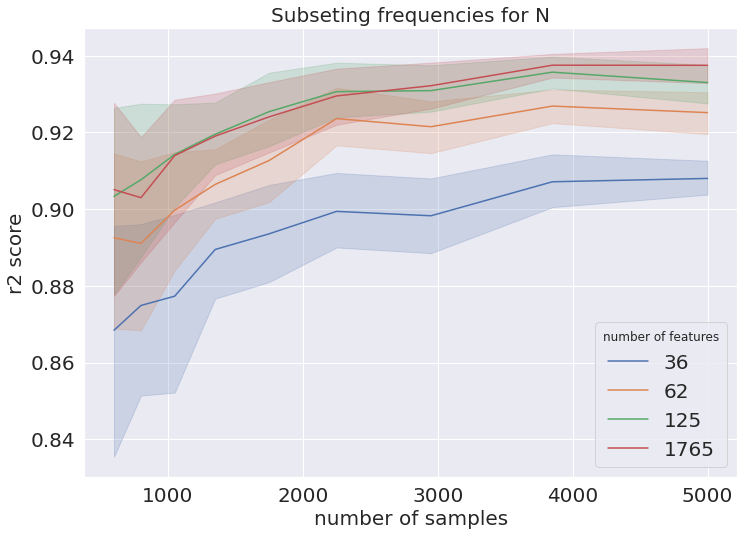

In [60]:
N = get_clean_analyte_df("N", target="N")
plot_subfreqs_comparison(N, "N", stratify="N")

getting cached cache/prod/get_clean_analyte_df/K#target:K#1f35b2b61e4f2fc90e9aa915f4cc5fa668745031e5e1d0a676af33f23cd0a9f9
getting cached cache/prod/get_clean_analyte_df/K#seed:2758999-target:K#2678468b51fab7d4b09a2dce4ac8ded28e13d4d96ca063949c661be2bd187101
getting cached cache/prod/train_model/df:shape:(5000, 1767)-K-xtrees_factory##2e5ec62d6e8fe604b75fe16ba3bd8ac40b0b253944b910c155ef0316d9db19a4
getting cached cache/prod/get_lc_geo/df:shape:(5000, 45)-K#stratify:K-seeds:667788,667789#2b0686539ec4047e0b69cdd182e8604b73c21cabfab3843dfa209ac7fbeb4bee
getting cached cache/prod/get_lc_geo/df:shape:(5000, 71)-K#stratify:K-seeds:667788,667789#f8c3a0f9b5b9fd3625ebb840e5d70d1a53faa9791ad9d3a449c5741337bc8218
getting cached cache/prod/get_lc_geo/df:shape:(5000, 141)-K#stratify:K-seeds:667788,667789#9d470c62310b02327c3898d04f55fdf7899711fddf465ddbadb4f9a88e1cdb3a
getting cached cache/prod/get_lc_geo/df:shape:(5000, 1766)-K#stratify:K-seeds:667788,667789#153ea7def14171d570e3398e1d728c003039167c

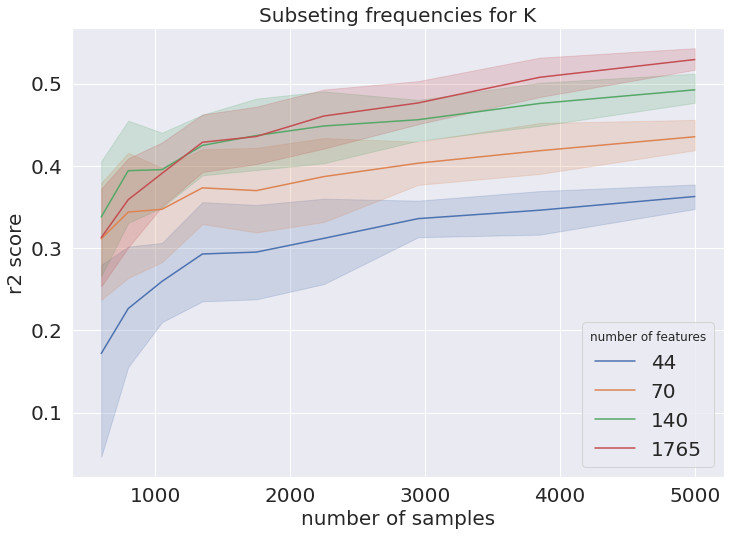

In [61]:
K = get_clean_analyte_df("K", target="K")

plot_subfreqs_comparison(K, "K", stratify="K")

getting cached cache/prod/get_clean_analyte_df/pH#target:pH#eece2ec627be570d1a225669f96944323a9f1e10062fbbb07f1eedf636f805e8
getting cached cache/prod/get_clean_analyte_df/pH#seed:2758999-target:pH#a82b89ad7ff83db481082ba435b5228132e0d4de2d2741fb56e09f189db98804
getting cached cache/prod/train_model/df:shape:(5000, 1767)-pH-xtrees_factory##7758a8a54849dda8909cbc4eeb906cf332d7cba866af6232321d7638781ce243
getting cached cache/prod/get_lc_geo/df:shape:(5000, 43)-pH#stratify:pH-seeds:667788,667789#01291c8f63b414b57df14d3dee9e4790a65a2ad5050672ac37424414b885a762
getting cached cache/prod/get_lc_geo/df:shape:(5000, 65)-pH#stratify:pH-seeds:667788,667789#db51a6eedd12eb001dbf5f2a7ad9348b23c7ddbe922d77e55273bb8f7faca813
getting cached cache/prod/get_lc_geo/df:shape:(5000, 139)-pH#stratify:pH-seeds:667788,667789#37967128a68aa59215f08eea3db1d85c89fde5b9337f5595b6231d8af1c4716c
getting cached cache/prod/get_lc_geo/df:shape:(5000, 1766)-pH#stratify:pH-seeds:667788,667789#dd9fde41be8cc9faf283de1296e

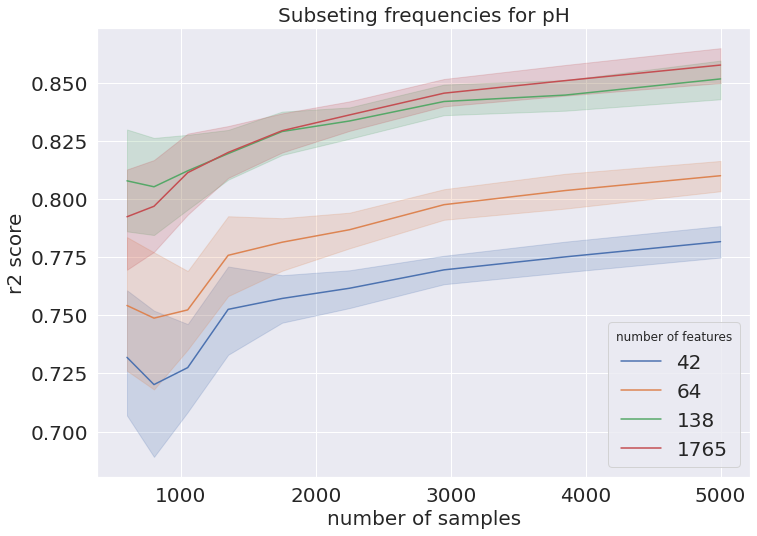

In [62]:
pH = get_clean_analyte_df("pH", target="pH")

plot_subfreqs_comparison(pH, "pH", stratify="pH")

getting cached cache/prod/get_clean_analyte_df/C##6b23c0d5f35d1b11f9b683f0b0a617355deb11277d91ae091d399c655b87940d
getting cached cache/prod/get_clean_analyte_df/C#seed:2758999-target:C#f917c5c4fe70ff90bc47f4c29c669521f5d8909a25af37e39baf8aefae17656d
getting cached cache/prod/train_model/df:shape:(5000, 1767)-C-xtrees_factory##e0565af4795905d7546d083cf7e457151e1b3fe0664f4ef49ff1637a2eeeb287
getting cached cache/prod/get_lc_geo/df:shape:(5000, 37)-C#stratify:C-seeds:667788,667789#3475b91f27035ab9a3273a62b24699a6fbe7f1ea307e9f876095e970ecd07bec
getting cached cache/prod/get_lc_geo/df:shape:(5000, 61)-C#stratify:C-seeds:667788,667789#6ed7a6440c014fb3b981949b06af8955f598be6f8e76e5a71b9d5b70eed31ca0
getting cached cache/prod/get_lc_geo/df:shape:(5000, 125)-C#stratify:C-seeds:667788,667789#8f642ea92bf8527717dba2a5c36244f80f7fc5bd1e7cfc66c67f30b545253100
getting cached cache/prod/get_lc_geo/df:shape:(5000, 1766)-C#stratify:C-seeds:667788,667789#e269c1b920dab697082d45aa987c95c0bdaeac003e97a56a

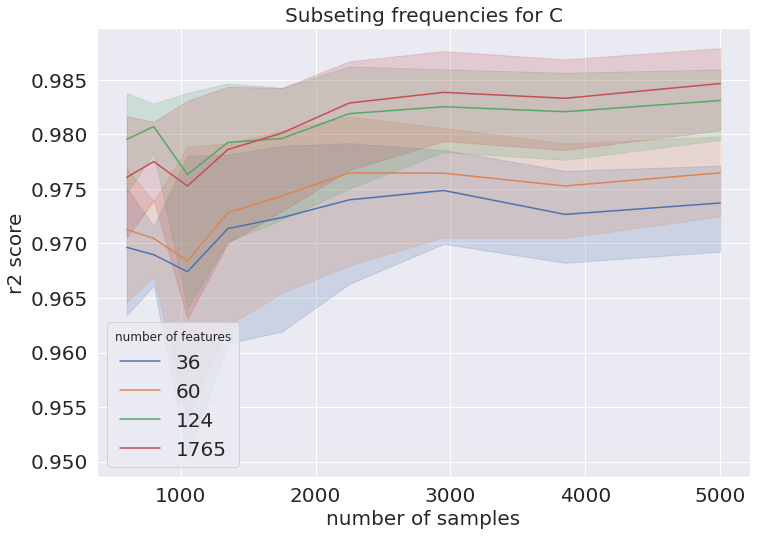

In [63]:
C = get_clean_analyte_df("C")

plot_subfreqs_comparison(C, "C", stratify="C")

# reporting utils


In [64]:
def conf_coeff(n, conf=0.95):
    return scipy.stats.t.ppf((1 + conf) / 2., n-1) / (n**(1/2))

def ci_error(x, conf=0.95):
    return np.std(x) * conf_coeff(len(x), conf)

def print_lc(lc, df_or_n=None, conf=0.95):
    if isinstance(df_or_n, DF):
        n = len(df_or_n.index)
    elif isinstance(df_or_n, int):
        n = df_or_n
    else:
        n = 0
            
    lc["size"] = (n * lc["frac"]).astype(int)
    def error(x):
        return ci_error(x)
    
    def lower(x):
        return x.mean() - error(x)
    
    def upper(x):
        return x.mean() + error(x)
    
    return lc.groupby(["frac", "size"]).agg(["mean", error, lower, upper])


def strat_comp(analyte, stratify, size, nb_seeds=10, df=None, stable=False, seed_=SEED, adverse=True, dfsize=5000):
    if isinstance(stratify, MultiStrat):
        strat_cols = list(stratify.keys())
    elif isinstance(stratify, str):
        strat_cols = [stratify]
    elif isinstance(stratify, OrderedStrat):
        strat_cols = [t[0] for t in stratify]
    else:
        assert False, stratify
        
    if df is None:
        df = get_clean_analyte_df(list(set([analyte] + strat_cols)), size=dfsize, target=analyte)
        
    if isinstance(size, float):
        size = int(len(df.index) * size)
        
    if stable:
        assert size <= (4/5) * len(df.index)
        
    scores = []
    for seed in range(seed_, seed_ + nb_seeds):
        print(f"evaluating with seed {seed}...")
        if stable:
            random_scores = cv_score(df, analyte, random_state=seed, train_subset_size=size)
            balanced_scores = cv_score(df, analyte, stratify=stratify, random_state=seed, train_subset_size=size)
            if adverse:
                adverse_scores = cv_score(df, analyte, stratify=stratify, adverse=True, random_state=seed, train_subset_size=size)
        else:
            subdf = df.sample(size, random_state=seed)
            random_scores = cv_score(subdf, analyte, random_state=seed)
            balanced_scores = cv_score(subdf, analyte, stratify=stratify, random_state=seed)
            if adverse:
                adverse_scores = cv_score(subdf, analyte, stratify=stratify, adverse=True, random_state=seed)
            
        scores += [("random", s) for s in random_scores]
        scores += [("balanced", s) for s in balanced_scores]
        if adverse:
            scores += [("adverserial", s) for s in adverse_scores]
        
    scores = DF(scores, columns=["stratification", "score"])
    return scores



In [65]:
def flatten_strat_comp(df, strat_by):
    if isinstance(strat_by, MultiStrat):
        strat_by = str(strat_by)
        
    if isinstance(strat_by, OrderedStrat):
        strat_by = str(strat_by)
        
    df["stratify by"] = strat_by
    return df
    
def compile_strat_comp(analyte, strats, size, nb_seeds=10, df=None, 
                       stable=False, seed_=SEED, adverse=True, dfsize="all"):
    
    rs = [strat_comp(analyte, s, size, nb_seeds=nb_seeds, df=df, 
                     stable=stable, seed_=seed_, adverse=adverse, dfsize=dfsize) for s in strats]
    
    rs = [flatten_strat_comp(r, s) for r, s in zip(rs, strats)]
    df = pd.concat(rs).reset_index(drop=True)
    
    df["score_clipped"] = np.where(df["score"] >= 0, df["score"], 0)
    
    # sort strat type 
    if adverse:
        sorter = DF({"stratification": ["adverserial", "random", "balanced"]})
    else:
        sorter = DF({"stratification": ["random", "balanced"]})
    df = sorter.merge(df, on="stratification")
    return df

def report_lc(analyte, strat, sizes, nb_seeds, df=None, stable=False, seed=SEED, dfsize="all"):
    dfs = []
    for size in sizes:
        scores = compile_strat_comp(analyte, [strat], size, nb_seeds, df, stable, seed, adverse=False, dfsize=dfsize)
        scores["size"] = size
        scores = scores.drop(columns=["score"])
        dfs.append(scores)
        
    return pd.concat(dfs).reset_index(drop=True).groupby(["size", "stratification"]).mean()


In [66]:

sizes = [100, 200, 300, 500, 1000, 2000]

report_lc("N", "clay", sizes=sizes, nb_seeds=10)


getting cached cache/prod/get_clean_analyte_df/N,clay#size:all-target:N#d537bc35e13e0f702cb9521f536d82d7851f2315965e7440fde72fcf76c89cb6
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-N#random_state:667788#2c02cd5936d8f8c7338c1f0034898d26e22183e392362f225b8e0874568f9dad
getting cached cache/prod/cv_score/df:shape:(100, 1768)-N#stratify:clay-random_state:667788#d0a467eff6badc2a557008befef5c7ed5dcbd0b8ae0e7d67eaeeae1b9139b9b9
evaluating with seed 667789...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-N#random_state:667789#31b67c22eba7eb6e24d307e7259baf90c0034b3ef8cb329f00a151e69f4bda12
getting cached cache/prod/cv_score/df:shape:(100, 1768)-N#stratify:clay-random_state:667789#c43a38e50d342281b95481e580b9bdd0791c372d10ce8d22ec3d5ebdc2452568
evaluating with seed 667790...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-N#random_state:667790#70b0b1a0bad7f37883150bd437ca235b4074125c90667674f056d51548355086
getting cached cache/prod/c

getting cached cache/prod/cv_score/df:shape:(300, 1768)-N#random_state:667794#6adef8296c1c0c6fcc2fccf1923b9974f1c1ba688006b2e5c6adc8e7308e5a01
getting cached cache/prod/cv_score/df:shape:(300, 1768)-N#stratify:clay-random_state:667794#71f7b6909bf5c2c0bf95bea139639fbc8e7142faee63be01b94525e45f44c3ff
evaluating with seed 667795...
getting cached cache/prod/cv_score/df:shape:(300, 1768)-N#random_state:667795#80179a1de592070c7afebe953e79d65a48bac32c2b81f4c943e64c1d7151338f
getting cached cache/prod/cv_score/df:shape:(300, 1768)-N#stratify:clay-random_state:667795#e13800a578e8a97505b75aad4f34b78a89fac0d907243b077db99baff041776b
evaluating with seed 667796...
getting cached cache/prod/cv_score/df:shape:(300, 1768)-N#random_state:667796#a4df673e39f499344a3e638bde4421661cd200dbb5c05e19f311078d5f18e8f8
getting cached cache/prod/cv_score/df:shape:(300, 1768)-N#stratify:clay-random_state:667796#e5f29eb5e239006c7bd70399d043eb41828ed662421de5cf5d07b57cc3d8756a
evaluating with seed 667797...
getting

evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-N#random_state:667788#8a72d73173070f31f8c7b9bb5b6d2ad4b0b432a11b9dbbe57970c522a2a78038
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-N#stratify:clay-random_state:667788#532bc2d9fc3dfbed21f9472542bb8dbe55a7319b6e957196d1155a8f18a63914
evaluating with seed 667789...
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-N#random_state:667789#7fb0d8e163229214489496e0e957a1b4e90561bfaaf1a2e0044ebbdd0371287f
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-N#stratify:clay-random_state:667789#2d71435b3fc9c0e54cad0ac064b86d2c310f1af825d8a14166bbbb95f7886547
evaluating with seed 667790...
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-N#random_state:667790#1e34660a312c53a3784e0acabbd37987ae3e1f590bef9a7fac11985dbe2be574
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-N#stratify:clay-random_state:667790#0872179c1bb739f37d33b6ea81eb63fcad77cd844562d0cad0c8852fdf29ce99
e

score_clipped
size stratification               
100  balanced             0.701267
     random               0.622429
200  balanced             0.798488
     random               0.711742
300  balanced             0.827861
     random               0.787423
500  balanced             0.840776
     random               0.816498
1000 balanced             0.870812
     random               0.853030
2000 balanced             0.886426
     random               0.875851

In [67]:
report_lc("N", "pH", sizes=sizes, nb_seeds=10)


getting cached cache/prod/get_clean_analyte_df/N,pH#size:all-target:N#d6d820df766b0db8a5723af99f0e488a4bf72b2b5e93d9f9b0d57754e275af6f
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-N#random_state:667788#e4b72efee2694c17498e883b304e1d375b452a7b600d58debc62f21c9793e168
getting cached cache/prod/cv_score/df:shape:(100, 1768)-N#stratify:pH-random_state:667788#1eba743560c00ca82e3d12fbb6ac2c6d87115e732c68d3cd7a3cff0e308ceb44
evaluating with seed 667789...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-N#random_state:667789#a16548a3294fb6009d38cf2512f3037594bf0aa01dbd3f4acd06b5fa24464a5f
getting cached cache/prod/cv_score/df:shape:(100, 1768)-N#stratify:pH-random_state:667789#0d1d01acad586be8d73d6037c4059dc3fb9f030126d4bde7ef2415e6320ab2eb
evaluating with seed 667790...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-N#random_state:667790#895a44e85748ca16d1cf66d088a06667d9405ef353cbafa37cfa5c7ffc1d9a90
getting cached cache/prod/cv_scor

getting cached cache/prod/cv_score/df:shape:(300, 1768)-N#stratify:pH-random_state:667794#fc1a6f412de0fe1a517e7b1b34f7e6614ac20d581006efe23bd27bce80a9cb75
evaluating with seed 667795...
getting cached cache/prod/cv_score/df:shape:(300, 1768)-N#random_state:667795#cac09a33a270209c7e740b1e864385190d53b28a6255de2d41f1d8718b91ca53
getting cached cache/prod/cv_score/df:shape:(300, 1768)-N#stratify:pH-random_state:667795#d7a3170360e8f2f47211d9c5552b73c2275f76b69509cbeac484f2b479578552
evaluating with seed 667796...
getting cached cache/prod/cv_score/df:shape:(300, 1768)-N#random_state:667796#78bdc3bba0cb748c9f7e7386ea2ac19dd92d41d6d98302e1c609bc322a38b713
getting cached cache/prod/cv_score/df:shape:(300, 1768)-N#stratify:pH-random_state:667796#7ce72befe6aeac982f3534fae2c30045096378c4736a4fd63f2a16c1aa66cae5
evaluating with seed 667797...
getting cached cache/prod/cv_score/df:shape:(300, 1768)-N#random_state:667797#5a811db811c60f6b1a965bb62433e6473516db303675336ccfada024a3b2fcee
getting cache

getting cached cache/prod/cv_score/df:shape:(2000, 1768)-N#random_state:667791#8ba54967c782ce825e95bf939267656cce7e6ce3878e126669d71a7ee1bc0b17
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-N#stratify:pH-random_state:667791#485cb9ea33846903112528034ea480cdd2bd39a7fb083a65ebb430a138fdf5a6
evaluating with seed 667792...
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-N#random_state:667792#27d242ef3bea154ad3143c8d3324e6fcc356381d67e545590718c9a1c4994830
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-N#stratify:pH-random_state:667792#2cbc4ce73f65d80efa1a8d4274a533039f887678f9c392bea54fa9b8295b399c
evaluating with seed 667793...
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-N#random_state:667793#bbd7a7a1fc0cc2ca88562174552485c0752ac69b2b3f07558073ec32ac3e915c
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-N#stratify:pH-random_state:667793#8a8590b7a2b9c7548edb411a5628d1a86a1f32804b18f6491917ee46baf25387
evaluating with seed 667794...
getting

score_clipped
size stratification               
100  balanced             0.760739
     random               0.644193
200  balanced             0.793962
     random               0.785282
300  balanced             0.871996
     random               0.847462
500  balanced             0.901284
     random               0.886802
1000 balanced             0.909408
     random               0.890313
2000 balanced             0.931364
     random               0.922406

In [68]:
report_lc("K", "clay", sizes=sizes, nb_seeds=10, dfsize="all")


getting cached cache/prod/get_clean_analyte_df/K,clay#size:all-target:K#4c4bcbb1c21b4eca40ef4bdd9515527b803ff7415308c0947012f55f93b4a91b
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-K#random_state:667788#fc20ab331d0050b8af98e6d3389fb3dacff035b4eceed3232dae51d575e955a4
getting cached cache/prod/cv_score/df:shape:(100, 1768)-K#stratify:clay-random_state:667788#ce38c8a5a1a72a4e53c4c3a8005b6614803b704a33645f19b0063db0658b9900
evaluating with seed 667789...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-K#random_state:667789#aafb77bedbb51ab2ad7214992f1fec7b28ea037a1913df10cc0df5b94f232f7a
getting cached cache/prod/cv_score/df:shape:(100, 1768)-K#stratify:clay-random_state:667789#d4ffa4c33056807d46b62fb4da050ee00bf0733bc8bf4b230a39956eb082840a
evaluating with seed 667790...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-K#random_state:667790#278f51c8fd5fb45217a8ff3d89a333a6912e0228df7a2c7a68fec69d3c6362a9
getting cached cache/prod/c

getting cached cache/prod/cv_score/df:shape:(300, 1768)-K#random_state:667795#5dcbaf00bd2e3166c34db578ff72b47345e97a8247c1f7145b7e00b7ad20c07f
getting cached cache/prod/cv_score/df:shape:(300, 1768)-K#stratify:clay-random_state:667795#a826f1c077b102942a1937698da17d7e5c2353ccc5f850cf8fa606610e0c29ad
evaluating with seed 667796...
getting cached cache/prod/cv_score/df:shape:(300, 1768)-K#random_state:667796#1eedea4c9e78dfd536217321b0ded6065add7f41918ff9472e4903c743ca89e9
getting cached cache/prod/cv_score/df:shape:(300, 1768)-K#stratify:clay-random_state:667796#3a43dd8940feaee26b498c8b08d0425dd88a4e293c467c50a89630813642cf01
evaluating with seed 667797...
getting cached cache/prod/cv_score/df:shape:(300, 1768)-K#random_state:667797#2a21ec67e2bfe4884a9110938ec0e9875ddf0fdc34f412f54b69e9407b1586aa
getting cached cache/prod/cv_score/df:shape:(300, 1768)-K#stratify:clay-random_state:667797#700e3752fba9cf2e8317d47e58cefc0f8bd99333dc27f9f1ddfeddb9afe99528
getting cached cache/prod/get_clean_an

getting cached cache/prod/cv_score/df:shape:(2000, 1768)-K#stratify:clay-random_state:667791#6152a229f64e67735245d0f462c59dbed84cf5e59feca6a30b20c12c4f0bc248
evaluating with seed 667792...
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-K#random_state:667792#0b91ebc3bd7d78de031a8227ecb3553e33d9ce23750abfc0dd5784b47217eb04
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-K#stratify:clay-random_state:667792#3625fb287e61b2b7f5d8ac724477112575d16272c8afd220cbed848761dae942
evaluating with seed 667793...
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-K#random_state:667793#e3eb10ddb96a30f71931685cadf8248d5f5405eb1b3722196aaa2d565df31957
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-K#stratify:clay-random_state:667793#ecb118afa324b2884efe2f77e4f5fe62a89ef338d53ec99720abd654dd18bf53
evaluating with seed 667794...
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-K#random_state:667794#4cf9a08ef0dd1ca4be032b518a4cef74478356d35ad1d06d3711af4cdb78cc4a
g

score_clipped
size stratification               
100  balanced             0.106061
     random               0.092835
200  balanced             0.133452
     random               0.114650
300  balanced             0.183744
     random               0.135902
500  balanced             0.243874
     random               0.166838
1000 balanced             0.348593
     random               0.270720
2000 balanced             0.434652
     random               0.394480

In [69]:
report_lc("C", "clay", sizes=sizes, nb_seeds=10, dfsize="all")


getting cached cache/prod/get_clean_analyte_df/C,clay#size:all-target:C#ea8c88ac052f27bf3a71b8d2fb7a0a12423e2f5db71e6ae488c6e6c1e551a940
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-C#random_state:667788#1c59fefe53ede8ae1aaa8addcea5f1c1cebdf3241c61b12dfd7805ce465791a2
getting cached cache/prod/cv_score/df:shape:(100, 1768)-C#stratify:clay-random_state:667788#f5b8927dbe344d31efbb84fcd83596d45776a6213bf04e1a341c3e25aae09235
evaluating with seed 667789...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-C#random_state:667789#507cc40f5095750e638a074f3d6e2f7dd659ada160fe4225059bc2833f53b79e
getting cached cache/prod/cv_score/df:shape:(100, 1768)-C#stratify:clay-random_state:667789#5da7941a5ae598f68c180cda3d0de2e6f99e3c8fc58aad96cf59eacefa09e14e
evaluating with seed 667790...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-C#random_state:667790#2efa3007894ade2b5d06d2e752ead2c3824abfb6b4ee6e58a8d142b94d80318d
getting cached cache/prod/c

getting cached cache/prod/cv_score/df:shape:(300, 1768)-C#stratify:clay-random_state:667794#c73387b219fb629ae96ad1aeebb3bd9f8567c7fa9bbc5a8623321b9c07d7ba75
evaluating with seed 667795...
getting cached cache/prod/cv_score/df:shape:(300, 1768)-C#random_state:667795#b0651d1fdaf5ba47e890457b0966844cac2024e5e90ad47071a96258e6764451
getting cached cache/prod/cv_score/df:shape:(300, 1768)-C#stratify:clay-random_state:667795#22f18a9bf31a12309c1a680bbc373d307bc6e468da114c12c03e0706996e900f
evaluating with seed 667796...
getting cached cache/prod/cv_score/df:shape:(300, 1768)-C#random_state:667796#44d22dc546e66a37907b5d029d7fb32105305cd96b9a548906f6f25fbb51429f
getting cached cache/prod/cv_score/df:shape:(300, 1768)-C#stratify:clay-random_state:667796#09ba05242044202590c211b1c6ba4ad15d9302a3f85cba01cd92ef6fe16873f9
evaluating with seed 667797...
getting cached cache/prod/cv_score/df:shape:(300, 1768)-C#random_state:667797#f6bec79a365c01081ed66dd659302acf3393067c4b137d7167677788353c3f8f
getting

evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-C#random_state:667788#583e16d1848db8a77b855653ac68258b0c5313cac3450247a68e719fbef1749f
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-C#stratify:clay-random_state:667788#7a861c46c23e461526c89ea6689c5d0d2883029970cbd346a5c7dff68a740869
evaluating with seed 667789...
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-C#random_state:667789#a00a7bfc7ce86226a21bf3686e4036332b8894166e9036b1732a6db509a4e75a
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-C#stratify:clay-random_state:667789#ff6e478f9523112e7a8281d1088ec30ec23683fc487b61cb855b4bfffefb80ae
evaluating with seed 667790...
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-C#random_state:667790#41aec1bb2ec26de44014c9a5ee5e644a550fecb7b40074a7549597fbba07b674
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-C#stratify:clay-random_state:667790#e4573993eab891a6086318715212b2dcd2e96f35cae21354a205ca24713760ef
e

score_clipped
size stratification               
100  balanced             0.762375
     random               0.715874
200  balanced             0.857160
     random               0.819054
300  balanced             0.882388
     random               0.851125
500  balanced             0.913588
     random               0.893653
1000 balanced             0.937839
     random               0.926237
2000 balanced             0.945315
     random               0.937757

In [70]:
report_lc("P2", "clay", sizes=sizes, nb_seeds=10, dfsize="all")


getting cached cache/prod/get_clean_analyte_df/P2,clay#size:all-target:P2#febd517b802adb131f1eb2138e3503367500799bc01699b5707d74e165b5e944
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-P2#random_state:667788#f07cefd86a4534a6c633405b44dae1ae4f3b7e8873ce80c8c76d9de1d25269b9
getting cached cache/prod/cv_score/df:shape:(100, 1768)-P2#stratify:clay-random_state:667788#e97141f3144bba2c0c93a8aa583e44a2fee88831e3d4e6fb02fdca6a18781ad0
evaluating with seed 667789...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-P2#random_state:667789#9bd316e5136578be9209f59879df7aae39ab8f2bacbb527a97567feb8c8b594b
getting cached cache/prod/cv_score/df:shape:(100, 1768)-P2#stratify:clay-random_state:667789#72905af68595a4e371b4c9dacf0c86ad265870d34adfd02a5bc79744e32835d4
evaluating with seed 667790...
getting cached cache/prod/cv_score/df:shape:(100, 1768)-P2#random_state:667790#c0848ab6199ee082c76bedd53b1f5cbbb3db6b2139aa79e791e74937f5e23797
getting cached cache

getting cached cache/prod/cv_score/df:shape:(300, 1768)-P2#random_state:667795#d4807afe2ac234bb5d567fb5573c93561bd583670da200b4ab3425e6add4a0cd
getting cached cache/prod/cv_score/df:shape:(300, 1768)-P2#stratify:clay-random_state:667795#a1873cc8896294a03a60202489997455ccb60d03c4fe9b42018c9e141a035aba
evaluating with seed 667796...
getting cached cache/prod/cv_score/df:shape:(300, 1768)-P2#random_state:667796#1b9c7f668304f59e5fc2f47b33f14cabad2ae48314424690d6b5b94a1cc0b4dd
getting cached cache/prod/cv_score/df:shape:(300, 1768)-P2#stratify:clay-random_state:667796#7f1ee25e0e1acd49ef230973f592e9ddf0b81dd9f845f2e5c03646f12266611c
evaluating with seed 667797...
getting cached cache/prod/cv_score/df:shape:(300, 1768)-P2#random_state:667797#546a6fd9b00feb5632dc51d7eda776233b7f8e41f5c8befd79f09f882c04ebd8
getting cached cache/prod/cv_score/df:shape:(300, 1768)-P2#stratify:clay-random_state:667797#8a85dfefaa522c84580bc6c242c637eff865c53903e2fc98a6a1b8aabd37c8ca
getting cached cache/prod/get_cl

getting cached cache/prod/cv_score/df:shape:(2000, 1768)-P2#random_state:667792#5ad6d5f7d2fd6f36c909c1be7192554cd330450e216e79052fb548fcdf9b2a9b
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-P2#stratify:clay-random_state:667792#ea7bf08405aa22090e8f80dd60c582f328b0da6880fccd693260af5a62476804
evaluating with seed 667793...
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-P2#random_state:667793#060fa957dc91e2b2b7431cc12030fa1ba7fff8e721f4fe5731cf597647d05a29
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-P2#stratify:clay-random_state:667793#f03606b80ae61cb1a2509f84b71a46e45e97712f92496792045c4d123efc4dd6
evaluating with seed 667794...
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-P2#random_state:667794#40d1de27ea82ccfd101d61ba310dfc8b87289a4f05fc46f57b39769f12569df6
getting cached cache/prod/cv_score/df:shape:(2000, 1768)-P2#stratify:clay-random_state:667794#6e359f264249dd3225cdefcfde084208d82f9255d7b598aeff9d818b23df5f76
evaluating with seed 66779

score_clipped
size stratification               
100  balanced             0.249991
     random               0.128313
200  balanced             0.238866
     random               0.154755
300  balanced             0.259923
     random               0.209671
500  balanced             0.321495
     random               0.253849
1000 balanced             0.403323
     random               0.342860
2000 balanced             0.454380
     random               0.412092

In [71]:

def dict_from_str(d):
    import ast
    try:
        x = ast.literal_eval(d)
        if isinstance(x, dict):
            return x
        return d
    except:
        return d

def pretty_key(k):
    mapping = {"lat_site": "LAT", "long_site": "LONG"}
    return mapping.get(k) or k

def pretty_multi_strat(strat):
    strat = dict_from_str(strat)
    if not isinstance(strat, dict):
        return strat
    
    singles = [f"{pretty_key(k)}:{v}" for k, v in strat.items()]
    if len(singles) == 1:
        return singles[0]
    
#     singles = [f"({x})" for x in singles]
    return " x ".join(singles)
        


def plot_compiled_strat_compar(analyte, strats, size, nb_seeds=10, df=None, stable=False, seed_=SEED, title=None):
    df = compile_strat_comp(analyte, strats, size, nb_seeds=nb_seeds, df=df, stable=stable, seed_=seed_)
    df["stratify by"] = df["stratify by"].apply(pretty_multi_strat)
    fig, ax = plt.subplots(1, 1, figsize=(22, 12))
    sns.barplot(data=df, x='score_clipped', y='stratify by', hue='stratification')
    fontsize = 30
    for c in ax.containers:
        ax.bar_label(c, fmt='%.2f', label_type='center', padding=-10, fontsize=fontsize)

    for label in ax.yaxis.get_ticklabels():
        plt.setp(label, fontsize=fontsize)

    for label in ax.xaxis.get_ticklabels():
        plt.setp(label, fontsize=fontsize)

    ax.set_ylabel("Stratify by", fontsize=fontsize)
    ax.set_xlabel("R2 score", fontsize=fontsize)

    # plt.legend(loc='upper right', bbox_to_anchor=(1.16,1), prop={"size": 20})
    plt.legend(prop={"size": 20})
    plt.title(title or analyte.title(), fontsize=fontsize)
#     fig.suptitle("QED - SIS: Comparing extra-trees performance on AfSIS and SIS", fontsize='21')

In [72]:
strats = [
    MultiStrat({"clay": 2}), 
    MultiStrat({"pH": 2}), 
    MultiStrat({"water": 2}), 
    MultiStrat({"clay": 2, "water":2}), 
    MultiStrat({"clay": 2, "pH":2}), 
#     OrderedStrat([("clay", 2), ("pH", 2)]),
    MultiStrat({"water": 2, "pH":2}), 
    MultiStrat({"lat_site": 2, "long_site": 2}),
#     MultiStrat({"lat_site": 2, "pH": 2}),
#     MultiStrat({"long_site": 2, "pH": 2}),
#     MultiStrat({"long_site": 2, "clay": 2}),
#     MultiStrat({"long_site": 2, "water": 2}),
#     MultiStrat({"lat_site": 2, "long_site": 2, "pH": 2}),
#     MultiStrat({"lat_site": 2, "long_site": 2, "clay": 2}),
#     OrderedStrat([("lat_site", 2), ("long_site", 2)]),
]

# plot_compiled_strat_compar("C", strats, size=400)

getting cached cache/prod/get_clean_analyte_df/C,clay#size:all-target:C#ea8c88ac052f27bf3a71b8d2fb7a0a12423e2f5db71e6ae488c6e6c1e551a940
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(200, 1768)-C#random_state:667788#9852e5aff345d010f7d73a35ed36c84dbeea90bef5af2e770ac97c352c5e50f2
evaluating with seed 667789...
getting cached cache/prod/cv_score/df:shape:(200, 1768)-C#random_state:667789#a139da943f774870316de5fb2d195420fc3d9a48bb581932dddcf307903b55c9
evaluating with seed 667790...
getting cached cache/prod/cv_score/df:shape:(200, 1768)-C#random_state:667790#18043c3078e66b2d30200fc1b13844b3cc5885525c80d3d80d8ea34b145c2f2c
evaluating with seed 667791...
getting cached cache/prod/cv_score/df:shape:(200, 1768)-C#random_state:667791#9faad17cdbc563b0535ad19b2a9b94bd7122e4ad150842269e0e901f222cfcb5
evaluating with seed 667792...
getting cached cache/prod/cv_score/df:shape:(200, 1768)-C#random_state:667792#2fe1b5fe8baeab79c808e0c1431485316b1b55ccadad8659890f60a870

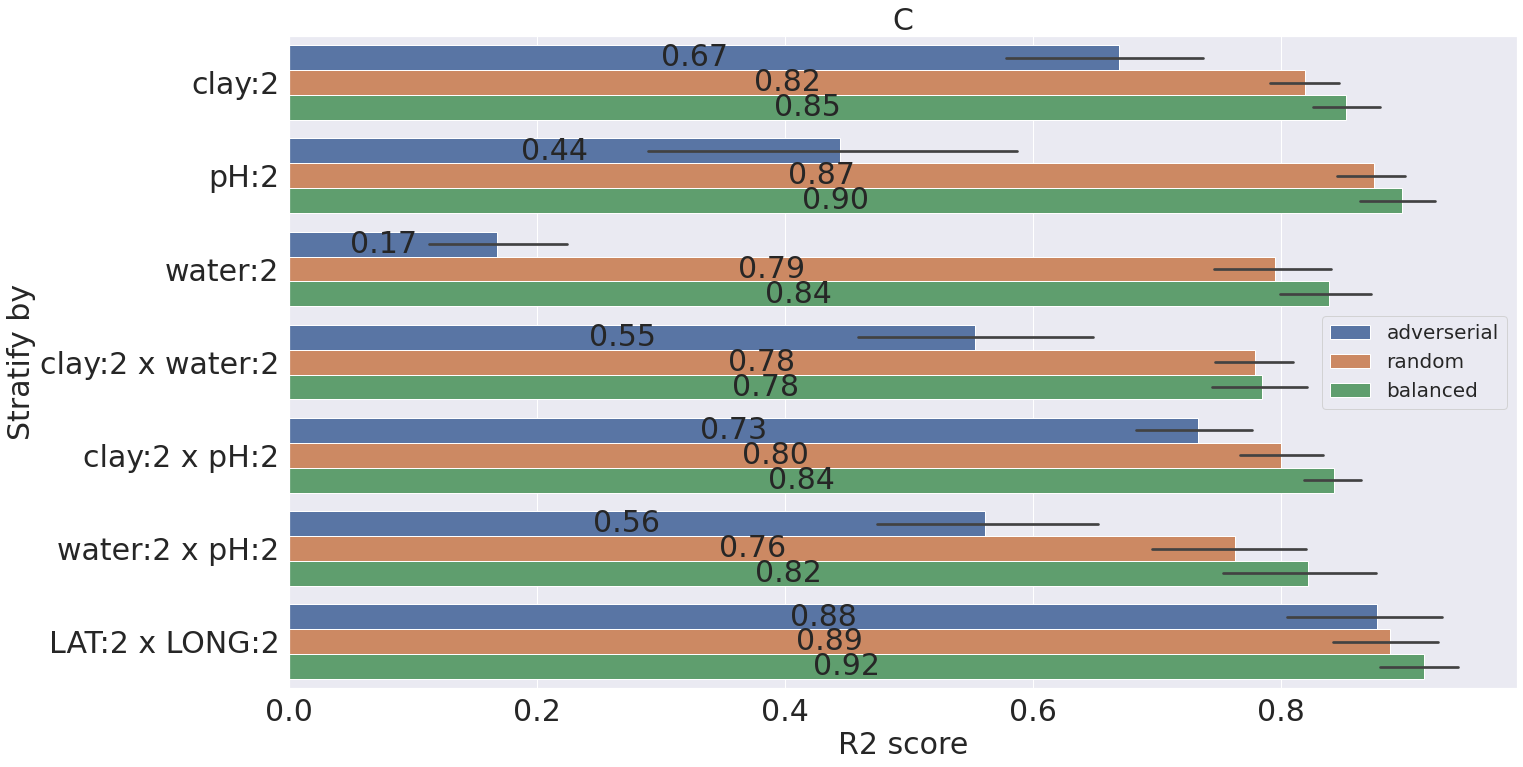

In [73]:
plot_compiled_strat_compar("C", strats, size=200)

In [74]:
# plot_compiled_strat_compar("C", strats, size=100)

getting cached cache/prod/get_clean_analyte_df/N,clay#size:all-target:N#d537bc35e13e0f702cb9521f536d82d7851f2315965e7440fde72fcf76c89cb6
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(400, 1768)-N#random_state:667788#32b04ac133c002c8d4c1a22d81c5fe2793d9ae93a8ac946ad4fb17a1a9eee161
evaluating with seed 667789...
getting cached cache/prod/cv_score/df:shape:(400, 1768)-N#random_state:667789#2b43b648c7896d9dd962a58f3950c8ef1f0e7abc845ea7606a1712a905a7f2af
evaluating with seed 667790...
getting cached cache/prod/cv_score/df:shape:(400, 1768)-N#random_state:667790#2c4e89345557257fe048a17a540fe512400bf8cf05c82f710551e5b62f1d871d
evaluating with seed 667791...
getting cached cache/prod/cv_score/df:shape:(400, 1768)-N#random_state:667791#23c20a5bc05611914c6b74ee1cee2ac5be1e6ae56ad52efc2f39dd343604c976
evaluating with seed 667792...
getting cached cache/prod/cv_score/df:shape:(400, 1768)-N#random_state:667792#fe995a72d2dea7aeaaa8074abb99b0c4b27b7ee354d13255ba3f5f6f20

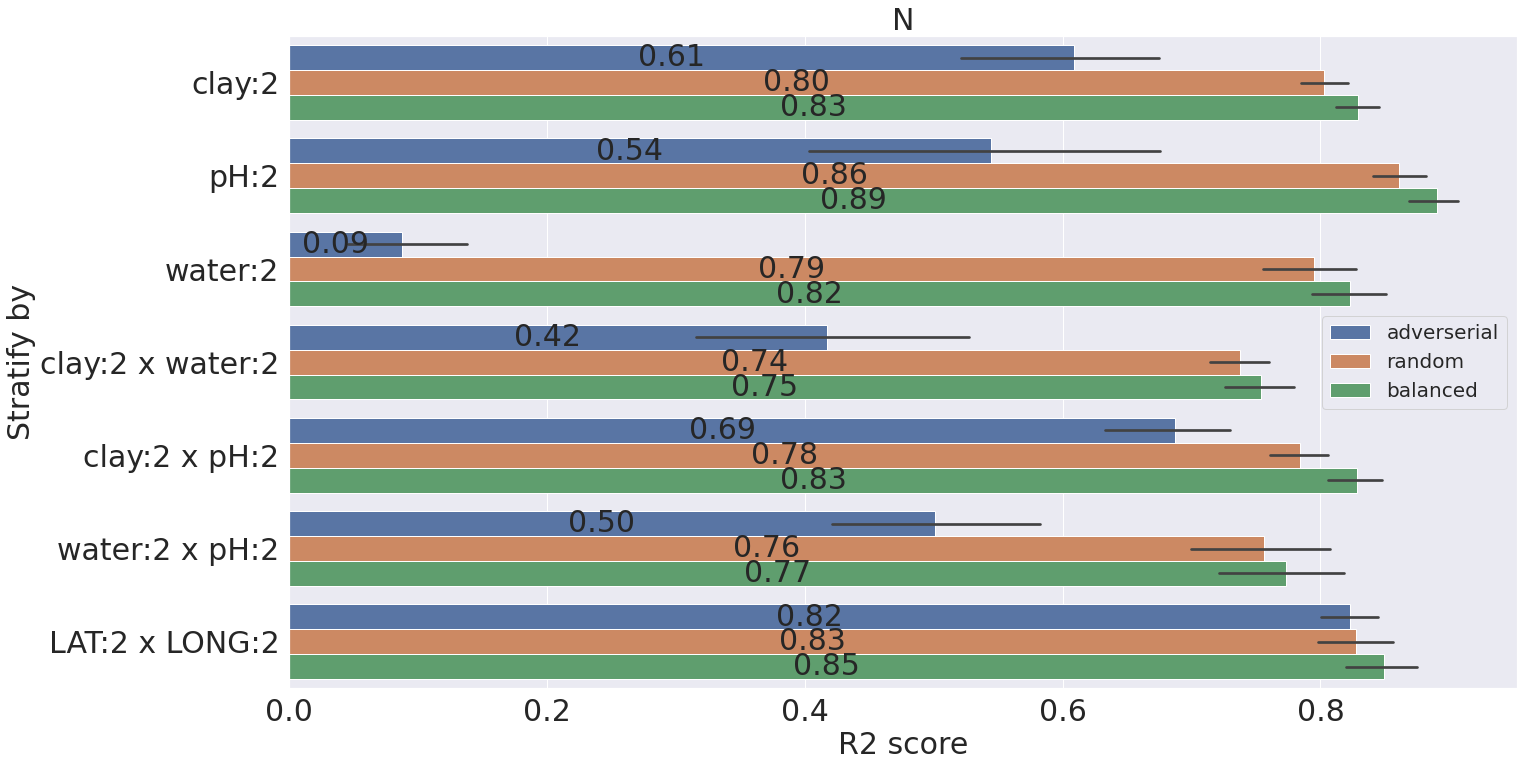

In [75]:
plot_compiled_strat_compar("N", strats, size=400)

In [76]:
# plot_compiled_strat_compar("N", strats, size=200)

In [77]:
# plot_compiled_strat_compar("N", strats, size=100)

getting cached cache/prod/get_clean_analyte_df/P2,clay#size:all-target:P2#febd517b802adb131f1eb2138e3503367500799bc01699b5707d74e165b5e944
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(1000, 1768)-P2#random_state:667788#a3191e7ecb65bf30ffeff33eb67b4d2cdd21ea8902296f8861841ab7cc57c01c
evaluating with seed 667789...
getting cached cache/prod/cv_score/df:shape:(1000, 1768)-P2#random_state:667789#e2d2f224045f2e00eb44adb293605949717465ed8b3b7f5c80fd866bd29de4d5
evaluating with seed 667790...
getting cached cache/prod/cv_score/df:shape:(1000, 1768)-P2#random_state:667790#4a6fb241aaf78f2f1ed940ee3789ca83b7b2d909f24689312dcfd4662404a695
evaluating with seed 667791...
getting cached cache/prod/cv_score/df:shape:(1000, 1768)-P2#random_state:667791#01225ad5a1498e217d79c69d7ea00ed1c9789636697ae005dad09291f9f72891
evaluating with seed 667792...
getting cached cache/prod/cv_score/df:shape:(1000, 1768)-P2#random_state:667792#f226a4fb1c9ef9abd4ac5789368b58beb781a7db0f2b79

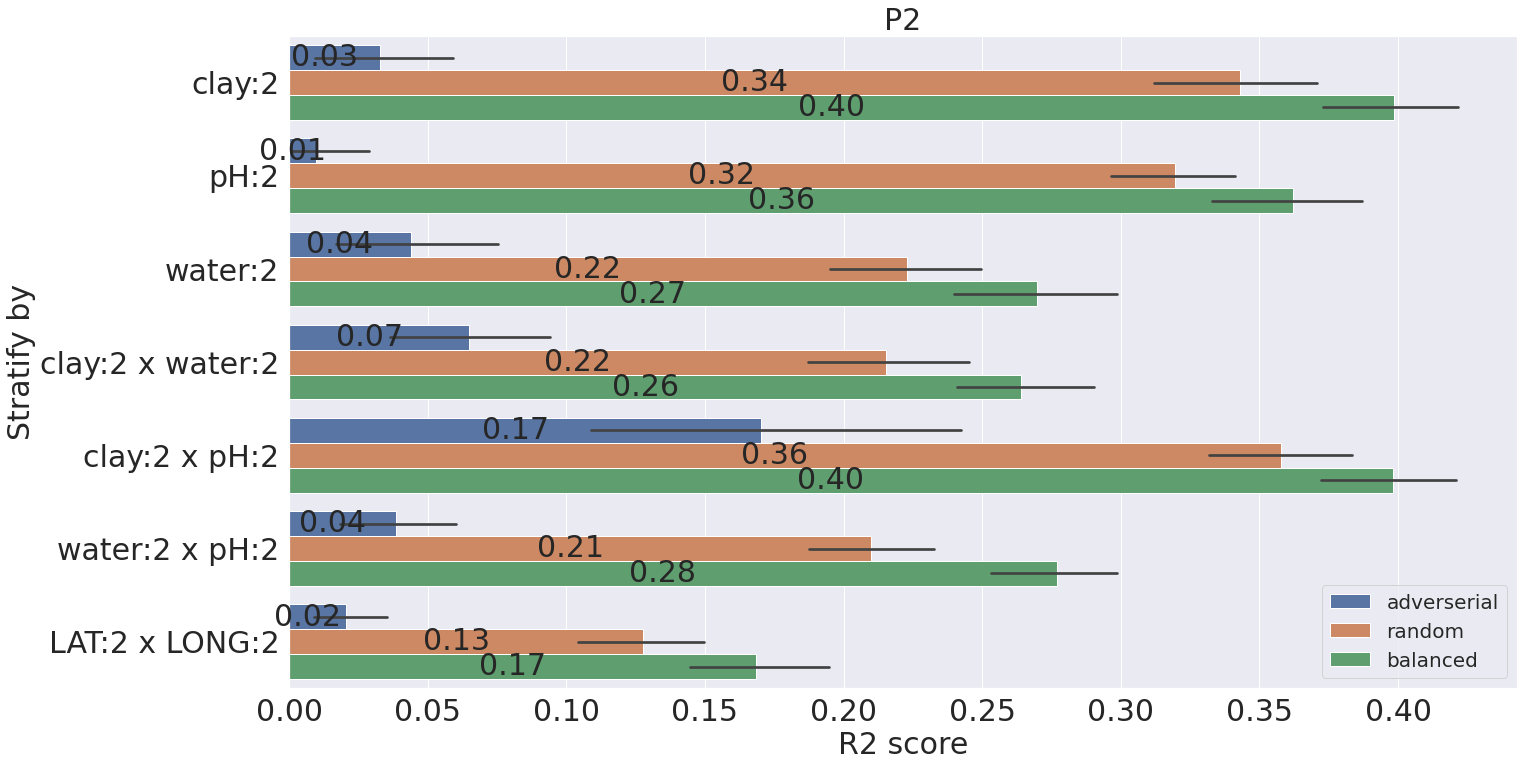

In [78]:
plot_compiled_strat_compar("P2", strats, size=1000) # by stratifying by clay 
# we were able to beat ng et al using only 1000 smaples

getting cached cache/prod/get_clean_analyte_df/K,clay#size:all-target:K#4c4bcbb1c21b4eca40ef4bdd9515527b803ff7415308c0947012f55f93b4a91b
evaluating with seed 667788...
getting cached cache/prod/cv_score/df:shape:(1000, 1768)-K#random_state:667788#8ffadd2543bb891419e8c7e1ad27ede3769030ca3a7006e1966f8e46f482663e
evaluating with seed 667789...
getting cached cache/prod/cv_score/df:shape:(1000, 1768)-K#random_state:667789#bbe51b5c78ca7d8643f06c1271c9f55e972af778410e73296514471b27b9b27c
evaluating with seed 667790...
getting cached cache/prod/cv_score/df:shape:(1000, 1768)-K#random_state:667790#b02c2147a177aad1f04081525dfecba02b6a0e9440dda8ee03d321b237684dd6
evaluating with seed 667791...
getting cached cache/prod/cv_score/df:shape:(1000, 1768)-K#random_state:667791#c337a844b793bc1f9b528915c436eb2c84a3524868fa532221cf0d78b7c2911f
evaluating with seed 667792...
getting cached cache/prod/cv_score/df:shape:(1000, 1768)-K#random_state:667792#17f1fadee3bdf49f02b3807075a7cce2615e8c2d425bc3a038444

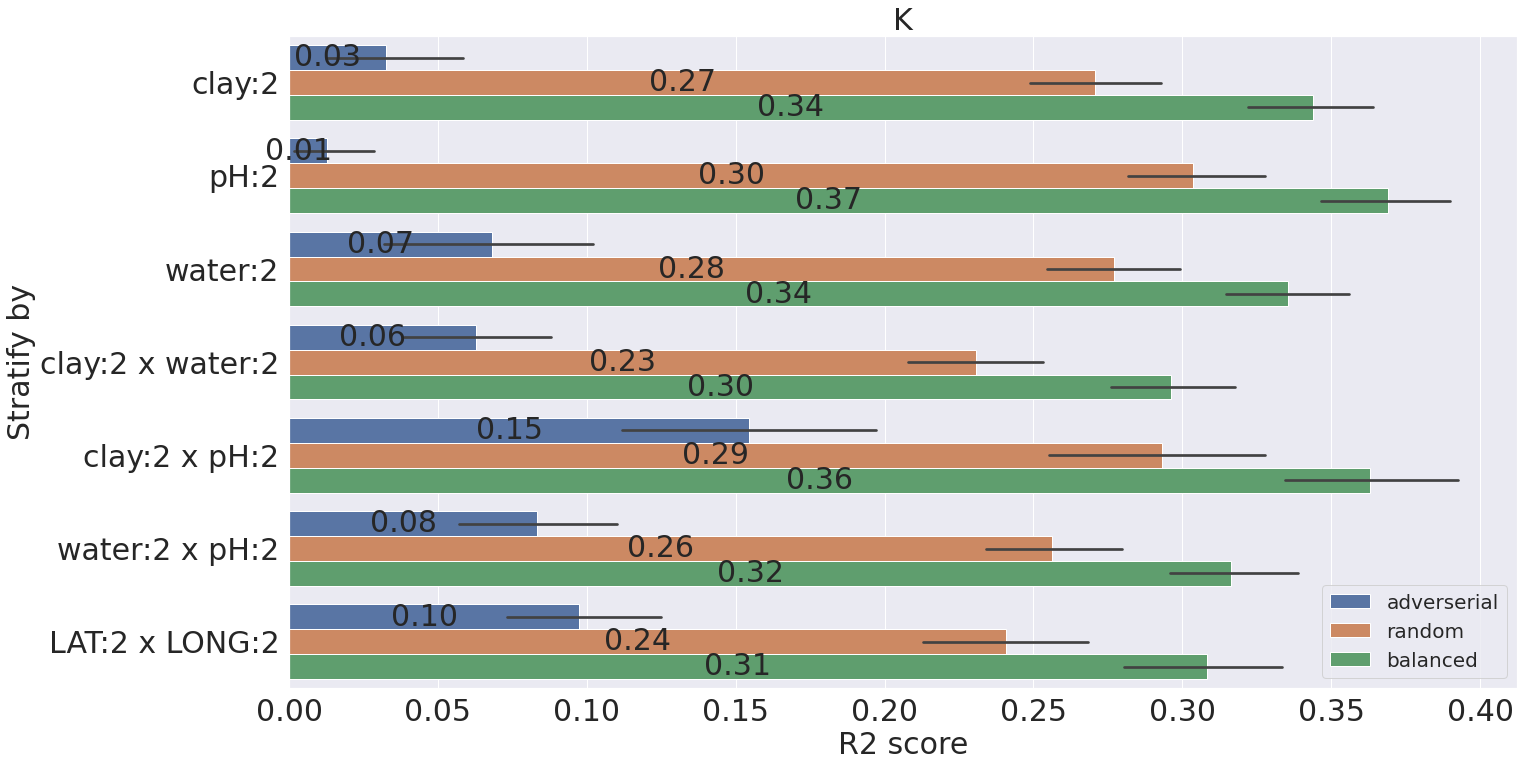

In [79]:
plot_compiled_strat_compar("K", strats, size=1000)

# Reporting


Text(0.5, 0.98, 'QED - SIS: Comparing extra-trees performance on AfSIS and SIS')

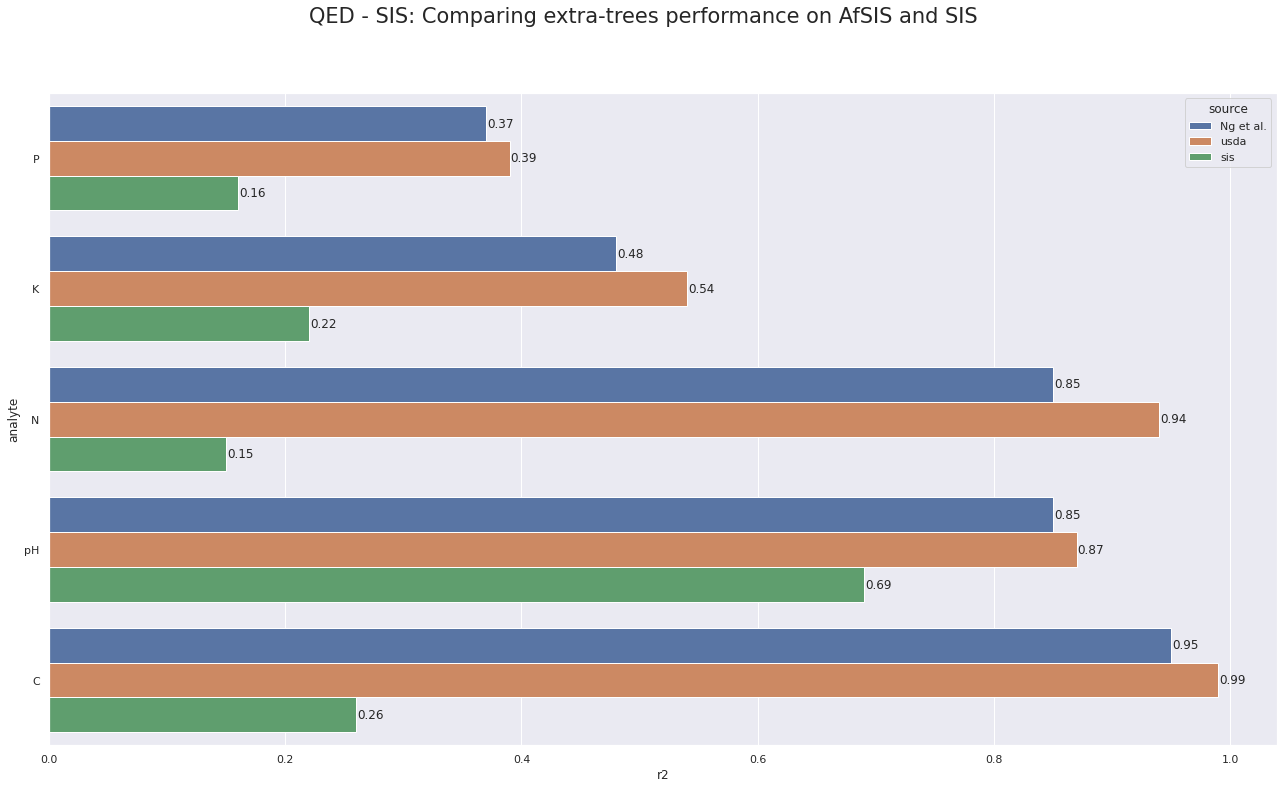

In [80]:
analytes = ["P", "K", "N", "pH", "C"]

ng_paper_scores = [
    ("P", 0.37),
    ("K", 0.48),
    ("N", 0.85),
    ("pH", 0.85),
    ("C", 0.95) # total, elemental
]

ng_df = DF(ng_paper_scores, columns=["analyte", "r2"])
ng_df["source"] = "Ng et al."

usda_scores = [
    ("P", 0.39),
    ("K", 0.54),
    ("N", 0.94),
    ("pH", 0.87),
    ("C", 0.99) # total, elemental
]
usda_res_df = DF(usda_scores, columns=["analyte", "r2"])
usda_res_df["source"] = "usda"

sis_scores = [
    ("P", 0.16),
    ("K", 0.22),
    ("N", 0.15),
    ("pH", 0.69),
    ("C", 0.26) # total, elemental
]
sis_res_df = DF(sis_scores, columns=["analyte", "r2"])
sis_res_df["source"] = "sis"

scores_df = pd.concat([ng_df, usda_res_df, sis_res_df])

fig, ax = plt.subplots(1, 1, figsize=(22, 12))
sns.barplot(data=scores_df, x='r2', y='analyte', hue='source')
for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', label_type='edge', padding=1)
fig.suptitle("QED - SIS: Comparing extra-trees performance on AfSIS and SIS", fontsize='21')
# fig.tight_layout()

In [81]:
cv_score(get_clean_analyte_df("P2", size=15000), analyte="P2").mean()

getting cached cache/prod/get_clean_analyte_df/P2#size:15000#675117906b6f01535c946ff983f6270fb1a181d88483589464ec0a44179254e3
getting cached cache/prod/cv_score/df:shape:(13868, 1767)#analyte:P2#d9e0145850e41a796996f924b466730c436d74aa33ba7e1ff853e0e722e795e1


0.5184509342960679

In [82]:
cv_score(get_clean_analyte_df("K", size=15000), analyte="K").mean()

getting cached cache/prod/get_clean_analyte_df/K#size:15000#ae473b1fb3d42a5ed98a1d6deb4b3259de98f3c1858b5687bc6718f1fc10b79a
getting cached cache/prod/cv_score/df:shape:(15000, 1767)#analyte:K#8352f3a12467828bf9b3b2c0e665ebed149af2e6930d7628936ad3dd85a3e556


0.591364445142977

In [83]:
cv_score(get_clean_analyte_df("N", size=15000), analyte="N").mean()

getting cached cache/prod/get_clean_analyte_df/N#size:15000#d8208424ffd46dd6fb507949ed7b53b0fbc736b6bc39750f8a9949bdf0096536
getting cached cache/prod/cv_score/df:shape:(15000, 1767)#analyte:N#1bd97071d5a7c0cc17d8853831e6ff64fae3b9c9819ed176cbbc5a314cd17d65


0.9465331339218412

In [84]:
cv_score(get_clean_analyte_df("pH", size=15000), analyte="pH").mean()

getting cached cache/prod/get_clean_analyte_df/pH#size:15000#6ecc87a9fd0292d8814448904ae8c5c4932c29b8a10c971428ee146779fe6e22
getting cached cache/prod/cv_score/df:shape:(15000, 1767)#analyte:pH#3ae7fffc0c4811c7fde92a41c0a190aaf50c5973a348574762e0eae00a172218


0.8668005962691241

In [85]:
cv_score(get_clean_analyte_df("C", size=15000), analyte="C").mean()

getting cached cache/prod/get_clean_analyte_df/C#size:15000#475bdfc2461c74a054adec99c65ee4c84a2fb7cf239bc897c8ad3ed9a7fa2126
getting cached cache/prod/cv_score/df:shape:(15000, 1767)#analyte:C#91cb69905f0afe43abec2738c6ad664923b5eacbd288d66036bc4907e8f35f7e


0.986935772294631

In [86]:
sis = get_clean_sis()
print("P", cv_score(sis, analyte="P").mean())
print("P strat P", cv_score(sis, analyte="P", stratify="P").mean())
print("P strat pH", cv_score(sis, analyte="P", stratify="pH").mean())

print("K", cv_score(sis, analyte="K").mean())
print("K strat K", cv_score(sis, analyte="K", stratify="K").mean())

print("N", cv_score(sis, analyte="N").mean())
print("N strat N", cv_score(sis, analyte="N", stratify="N").mean())
print("pH", cv_score(sis, analyte="pH").mean())
print("pH strat", cv_score(sis, analyte="pH", stratify="pH").mean())
print("EC", cv_score(sis, analyte="EC").mean())
print("C strat C", cv_score(sis, analyte="EC", stratify="EC").mean())

getting cached cache/prod/get_clean_sis/##e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855
getting cached cache/prod/cv_score/df:shape:(3181, 1714)#analyte:P#2bba8eba35dc7d92b263c87cd470a43aa8d6f2096d992ac8d95fd26f52b920a0
P 0.16118765900755416
getting cached cache/prod/cv_score/df:shape:(3181, 1714)#analyte:P-stratify:P#688c2c7b8b35c791422791c1a1ef5b2dcc41c5bcf90c09ad5395f5c99bb751b5
P strat P 0.17043236078231025
getting cached cache/prod/cv_score/df:shape:(3181, 1714)#analyte:P-stratify:pH#eea1c172118c6ed99cb4bf1c3d56ec2cc7a10e3bc96010f2597a1bc248d06309
P strat pH 0.16704447735815722
getting cached cache/prod/cv_score/df:shape:(3181, 1714)#analyte:K#adb6979a9e9a8290190bed50a30fc6fb5fdd29cd13f76731463b2ada278f1a85
K 0.19312872740713735
getting cached cache/prod/cv_score/df:shape:(3181, 1714)#analyte:K-stratify:K#59a2c7e04fd29a44720154b75701f519b041e2cb41549183ce9d3a3dff7de843
K strat K 0.22591879700644144
getting cached cache/prod/cv_score/df:shape:(3181, 1714)#analyte

# Selecting representatives from each strata

In [87]:


@cached("get_stratified_df")
def get_stratified_df(analyte, analytes_to_n, seed=SEED, drop_outliers=False, group_size=10):
    df = get_usda_analyte_df(list(analytes_to_n.keys()) + [analyte], size="all")
    if drop_outliers:
        for a in analytes_to_n:
            df = drop_outliers_for_analyte(df, a)
    for ana, n in analytes_to_n.items():
        df[f"{ana}_discrete"] = discretize_series(df[ana], n)
        
    discrete_cols = [f"{ana}_discrete" for ana in analytes_to_n]
    df = df.sample(frac=1, random_state=seed)
    unique = df.groupby(discrete_cols).head(group_size)
    raw = df.loc[unique.index].reset_index(drop=True).drop(columns=discrete_cols)
    return standard_clean(raw)
    


def uniformize_distribution(df, analytes_to_n, group_size, seed=SEED):
    df = df.copy()
    for ana, n in analytes_to_n.items():
        df[f"{ana}_discrete"] = discretize_series(df[ana], n)
        
    discrete_cols = [f"{ana}_discrete" for ana in analytes_to_n]
    df = df.sample(frac=1, random_state=seed)
    unique = df.groupby(discrete_cols).head(group_size)
    df = df.loc[unique.index].reset_index(drop=True).drop(columns=discrete_cols)
    return df

# What's going on here????

In [136]:

def get_chunks(df):
    df = df.copy()
    n = len(df.index)
    smp_size = n // 5
    subdfs = []
    for i in range(5):
        chunk = df.iloc[smp_size*i: smp_size* (i+1)]
        subdfs.append(chunk)
    
        
    return subdfs

def train_test_from_chunks(chunks, i):
    train_dfs = chunks[:i] + chunks[i+1:]
    train = pd.concat(train_dfs, axis=0)
    return train, chunks[i]

def select_strat_cv_score(df, analyte, strat_select_fn, seed=SEED):
    df = df.copy()
    df = df.reset_index(drop=True)
    df = df.sample(frac=1, random_state=seed)
    chunks = get_chunks(df)
    
    scores = []
    for i in range(5):
        train, test = train_test_from_chunks(chunks, i)
        train_df = strat_select_fn(train)

        model = train_model(train_df, analyte)
        scores.append(test_model(model, test, analyte))
        
    return np.array(scores)







In [89]:
def plot_granularity_comp(df, analyte, strat, n, group_sizes=None):
    all_scores = []
    if group_sizes is None:
        group_sizes = [d for d in range(1, n + 1) if n % d == 0]
    for group_size in group_sizes:
        n_groups = n // group_size
        select_fn = lambda x: uniformize_distribution(x, {strat: n_groups}, group_size=group_size)
        scores = select_strat_cv_score(df, analyte, select_fn)
        all_scores += [(group_size, score) for score in scores]
            
    scores_df = DF(all_scores, columns=["group_size", "score"])
    sns.barplot(data=scores_df, x="group_size", y="score")
            


In [90]:
@attr.define
class SelectStrat:
    strat_dict: dict
    size: int
    correct: bool = attr.field(default=True)
        
    def group_size(self):
        nb_groups = reduce(lambda x, y: x*y, self.strat_dict.values())
        res = self.size // nb_groups
        if self.correct:
            res = int(res * 0.8)
            
        return res
    
    
@cached("compare_multi_strats_corr")
def compare_multi_strats(analyte, strat_dict, size, seeds=(SEED, ), df=None, dfsize=5000, correct=True):
    if df is None:
        analytes = list(set([analyte] + list(strat_dict.keys())))
        df = get_clean_analyte_df(analytes, size=dfsize, target=analyte, seed=SEED)
    mstrats = {}
    mstrats["select_strat"] = SelectStrat(strat_dict, size, correct=correct)
    mstrats["multi_strat"] = MultiStrat(strat_dict)
    nb_strata = reduce(lambda x, y: x*y, strat_dict.values())
    mstrats["cluster_strat"] = ClusterStrat(strats_by=strat_dict, nb_clusters=nb_strata)
    mstrats["recursive_strat"] = OrderedStrat(strat_dict.items())
    mstrats["no_strat"] = None
    
    dfs = []
    for seed in seeds:
        print(f"evaluating with seed {seed}")
        for stname, strat in mstrats.items():
            if isinstance(strat, SelectStrat):
                def _select_fn(_df):
                    return uniformize_distribution(_df, strat.strat_dict, strat.group_size(), seed=seed)
                
                scores = select_strat_cv_score(df, analyte, _select_fn)
            else:
                data = df.sample(n=size, random_state=seed)
                scores = cv_score(data, analyte, stratify=strat, random_state=seed)
                
            scores_df = DF(scores, columns=["score"])
            scores_df["strat"] = stname
            dfs.append(scores_df)
            
    return pd.concat(dfs).reset_index(drop=True).groupby("strat").mean()
    
    
def report_multi_strats(analyte, strat_dict, size, seeds=(SEED, ), df=None, dfsize=5000, correct=True):
    if df is None:
        analytes = list(set([analyte] + list(strat_dict.keys())))
        df = get_clean_analyte_df(analytes, size=dfsize, target=analyte, seed=SEED)
        
    result = compare_multi_strats(analyte, strat_dict, size, seeds=seeds, df=df, dfsize=dfsize, correct=correct)
    print(f" ### kl div of distribution from uniform: {kl_div_of_strat(df, MultiStrat(strat_dict))}")
    print(f" ### strata distribution: {cartesian_strata_sizes(df, MultiStrat(strat_dict))}")
    
    return result

In [91]:
seeds = range(SEED, SEED+5)

report_multi_strats("N", {"clay":2, "water":2}, size=400, seeds=seeds)



collecting data for ['N', 'clay', 'water']...
getting cached cache/prod/get_usda_analyte_df/N,clay,water-5150-667788#keep_spec:first#5413e15d552c1323f28ee7d262296d5cf43964cab4b86580d7b877ee2dbba6db
size after droping: 5000
preprocessing specs...
evaluating with seed 667788
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667789
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667790
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667791
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667792
training on fu

,score
strat,
cluster_strat,0.666594
multi_strat,0.698524
no_strat,0.585779
recursive_strat,0.669076
select_strat,0.740005


In [137]:
report_multi_strats("N", {"clay":2, "water":2}, size=400, dfsize="all", seeds=seeds)


getting cached cache/prod/get_clean_analyte_df/water,N,clay#size:all-target:N-seed:667788#2b522f2254e24f81d1e50262c2fc3074abf81740fdd802fb4a56d205bcc49ee2
getting cached cache/prod/compare_multi_strats_corr/N-{'clay': 2, 'water': 2}-400#seeds:range(667788, 667793)-df:df:shape:(30831, 1769)-dfsize:all-correct:True#a40951269394d12cc94a87b93443863f23222422543725bbb84e54bd2ff566e8
 ### kl div of distribution from uniform: 227.48608277458067
 ### strata distribution: [12699 12698  2717  2717]


,score
strat,
cluster_strat,0.771159
multi_strat,0.760843
no_strat,0.722581
recursive_strat,0.761900
select_strat,0.794972


In [92]:
report_multi_strats("N", {"clay":2, "water":2}, size=400, seeds=seeds, correct=True)


getting cached cache/prod/get_clean_analyte_df/water,N,clay#size:5000-target:N-seed:667788#1158db2f53dbf0a7a61d11f1c30fd46448a8c71a8e64c5cc75f2228234f328d6
getting cached cache/prod/compare_multi_strats_corr/N-{'clay': 2, 'water': 2}-400#seeds:range(667788, 667793)-df:df:shape:(5000, 1769)-dfsize:5000-correct:True#6d182331e1a84cfc0a79a45858ef11d5af8092ecfa6138e2d723c5323b777f4d
 ### kl div of distribution from uniform: 215.74219462857286
 ### strata distribution: [2040 2040  460  460]


,score
strat,
cluster_strat,0.666594
multi_strat,0.698524
no_strat,0.585779
recursive_strat,0.669076
select_strat,0.740005


In [93]:
report_multi_strats("N", {"clay":2, "water":2}, size=400, seeds=seeds, dfsize="all")

collecting data for ['N', 'clay', 'water']...
getting cached cache/prod/get_usda_analyte_df/N,clay,water-all-667788#keep_spec:first#90c0e4fb181b78446b565d7631a354c2745260281f41c95d08bf4711005deed2
size after droping: 30831
preprocessing specs...
getting cached cache/prod/compare_multi_strats_corr/N-{'clay': 2, 'water': 2}-400#seeds:range(667788, 667793)-df:df:shape:(30831, 1769)-dfsize:all-correct:True#a40951269394d12cc94a87b93443863f23222422543725bbb84e54bd2ff566e8
 ### kl div of distribution from uniform: 227.48608277458067
 ### strata distribution: [12699 12698  2717  2717]


,score
strat,
cluster_strat,0.771159
multi_strat,0.760843
no_strat,0.722581
recursive_strat,0.761900
select_strat,0.794972


In [ ]:
report_multi_strats("N", {"pH":2, "clay":2}, size=400, seeds=seeds, dfsize="all")

getting cached cache/prod/get_clean_analyte_df/N,pH,clay#size:all-target:N-seed:667788#4ae1cb223998f727e479d88d8ff60f00a39af5072cc655c2e846cbce99c6190a
evaluating with seed 667788


In [143]:
with open("cache/prod/compare_multi_strats/N-{'pH': 2, 'clay': 2}-400#seeds:range(667788, 667793)-df:df:shape:(5000, 1769)-dfsize:5000#ccfbb5feba414db79e99c36676dcca047e2c2249ca513ae3de1d5302efe7ddc2", "rb") as f:
    import pickle
    r = pickle.load(f)
    
    
r



,score
strat,
cluster_strat,0.810789
multi_strat,0.791305
no_strat,0.762882
recursive_strat,0.813608
select_strat,0.836450


In [94]:
report_multi_strats("N", {"pH":2, "clay":2}, size=400, seeds=seeds)

collecting data for ['N', 'clay', 'pH']...
getting cached cache/prod/get_usda_analyte_df/N,clay,pH-5150-667788#keep_spec:first#a1f9d7ad18b7979d81181cda7d3e522228dff2fd5bb15e347dd51ff614275b87
size after droping: 5000
preprocessing specs...
evaluating with seed 667788
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667789
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667790
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667791
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667792
training on full dat

,score
strat,
cluster_strat,0.844487
multi_strat,0.843765
no_strat,0.815173
recursive_strat,0.833238
select_strat,0.834453


In [95]:
report_multi_strats("N", {"water":2, "pH":2}, size=400, seeds=seeds)

collecting data for ['N', 'pH', 'water']...
getting cached cache/prod/get_usda_analyte_df/N,pH,water-5150-667788#keep_spec:first#ecda6ca70cb02319343da908504f515b65038c39f7f799ba1310ca5ab82f1a93
size after droping: 5000
preprocessing specs...
evaluating with seed 667788
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


evaluating with seed 667789
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667790
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667791
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667792
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
 ### kl div of distribution from uniform: 0.4650338657880785
 ### strata distribution: [1291 1285 1215 1209]


,score
strat,
cluster_strat,0.805841
multi_strat,0.809901
no_strat,0.788667
recursive_strat,0.812120
select_strat,0.834583


In [96]:
report_multi_strats("N", {"water":2, "pH":2}, size=400, seeds=seeds, dfsize="all")

collecting data for ['N', 'pH', 'water']...
getting cached cache/prod/get_usda_analyte_df/N,pH,water-all-667788#keep_spec:first#ec2f40878b9e5ab7da9cf599b7ec2a8d675caf13ec450ed065465fca02a32f9d
size after droping: 31782
preprocessing specs...
getting cached cache/prod/compare_multi_strats_corr/N-{'water': 2, 'pH': 2}-400#seeds:range(667788, 667793)-df:df:shape:(31782, 1769)-dfsize:all-correct:True#b81995eab7aef731ddf3e97c9aea205b1ec72a070bf9e2d7f270ccacbe38f94a
 ### kl div of distribution from uniform: 0.7918485632391441
 ### strata distribution: [8288 8233 7657 7604]


,score
strat,
cluster_strat,0.829560
multi_strat,0.821820
no_strat,0.803300
recursive_strat,0.836922
select_strat,0.844276


In [97]:
report_multi_strats("N", {"lat_site":2, "long_site":2}, size=400, seeds=seeds)

collecting data for ['N', 'lat_site', 'long_site']...
getting cached cache/prod/get_usda_analyte_df/N,lat_site,long_site-5150-667788#keep_spec:first#239038e2ab4c0ba293ccf779e181ecd6dd14e02f0266f9501a2f68cd9c2e861f
size after droping: 5000
preprocessing specs...
evaluating with seed 667788
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667789
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667790
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667791
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 66779

,score
strat,
cluster_strat,0.850748
multi_strat,0.855621
no_strat,0.852643
recursive_strat,0.866776
select_strat,0.869402


In [154]:
report_multi_strats("N", {"lat_site":2, "long_site":2}, size=400, seeds=seeds, dfsize="all")

collecting data for ['long_site', 'N', 'lat_site']...
getting cached cache/prod/get_usda_analyte_df/long_site,N,lat_site-all-667788#keep_spec:first#30bcd7f762910de92d2858e539f498ea311dbddbe0256a50d151ed5c197007c8
size after droping: 34348
preprocessing specs...
evaluating with seed 667788
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
getting cached cache/prod/cv_score/df:shape:(400, 1769)-N#stratify:{'lat_site': 2, 'long_site': 2}-random_state:667788#678a672d491fd933bfad589be7e3e2d18fad798a63dee679d4dd02a18f4a97d9
evaluating with seed 667789
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
getting cached cache/prod/cv_score/df:shape:(400, 1769)-N#stratify:{'lat_site': 2, 'long_site': 2}-random_state:667789#92f7be6b45781cd7e8090d208c567ffc405a178d1cfe95065c8049fa0c2d7181
evaluating wit

,score
strat,
cluster_strat,0.826136
multi_strat,0.829605
no_strat,0.831557
recursive_strat,0.823515
select_strat,0.866732


In [98]:
report_multi_strats("P2", {"water":2, "clay":2}, size=800, seeds=seeds)

collecting data for ['P2', 'clay', 'water']...
getting cached cache/prod/get_usda_analyte_df/P2,clay,water-5150-667788#keep_spec:first#11ce6b0f8aa7f72ad20a08e9bbbd6e64f051af6c2f41f94ccba102909574defc
size after droping: 3616
preprocessing specs...
evaluating with seed 667788
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667789
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667790
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667791
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667792
training on 

,score
strat,
cluster_strat,0.250879
multi_strat,0.247067
no_strat,0.177796
recursive_strat,0.229581
select_strat,0.229645


In [99]:
report_multi_strats("P2", {"water":2, "pH":2}, size=800, seeds=seeds)

collecting data for ['P2', 'pH', 'water']...
getting cached cache/prod/get_usda_analyte_df/P2,pH,water-5150-667788#keep_spec:first#63cb73af94dcab63b6529075563137739426f3960701292259c3fa468e6a4893
size after droping: 3635
preprocessing specs...
evaluating with seed 667788
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667789
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667791
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


evaluating with seed 667792
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


 ### kl div of distribution from uniform: 0.04036806320288026
 ### strata distribution: [920 912 905 898]


,score
strat,
cluster_strat,0.231294
multi_strat,0.221653
no_strat,0.169956
recursive_strat,0.222802
select_strat,0.240266


In [100]:
report_multi_strats("P2", {"pH":2, "clay":2}, size=800, seeds=seeds)

collecting data for ['P2', 'clay', 'pH']...
getting cached cache/prod/get_usda_analyte_df/P2,clay,pH-5150-667788#keep_spec:first#9617ca9b6684ee6e92b2463dfe3257187279932505d95fa12de2ed8acf69d78c
size after droping: 5000
preprocessing specs...
evaluating with seed 667788
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667789
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667790
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667791
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667792
training on full d

,score
strat,
cluster_strat,0.362442
multi_strat,0.363763
no_strat,0.303702
recursive_strat,0.362949
select_strat,0.352294


In [101]:
report_multi_strats("P2", {"lat_site":2, "long_site":2}, size=800, seeds=seeds)

collecting data for ['P2', 'lat_site', 'long_site']...
getting cached cache/prod/get_usda_analyte_df/P2,lat_site,long_site-5150-667788#keep_spec:first#c00cc3d79d662533676c6235840fb3959989d37d9e88902aa52896e4297b6045
size after droping: 4417
preprocessing specs...
evaluating with seed 667788
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667789
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667790
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667791
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667

,score
strat,
cluster_strat,0.140130
multi_strat,0.141396
no_strat,0.094573
recursive_strat,0.157235
select_strat,0.157256


In [102]:
report_multi_strats("K", {"water":2, "clay":2}, size=800, seeds=seeds)

collecting data for ['K', 'clay', 'water']...
getting cached cache/prod/get_usda_analyte_df/K,clay,water-5150-667788#keep_spec:first#bd88d979cb744f546796f27e631919c5ffab1561cc15b3cbb49a89a9b4a63c2f
size after droping: 5000
preprocessing specs...
evaluating with seed 667788
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667789
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667790
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667791
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667792
training on fu

,score
strat,
cluster_strat,0.275378
multi_strat,0.277388
no_strat,0.202471
recursive_strat,0.263975
select_strat,0.236032


In [103]:
report_multi_strats("K", {"water":2, "pH":2}, size=600, seeds=seeds)

collecting data for ['K', 'pH', 'water']...
getting cached cache/prod/get_usda_analyte_df/K,pH,water-5150-667788#keep_spec:first#f1663d511f349a06b0ed6428fb9433945c5cd50aae4d37c6ad05763f4f7cd631
size after droping: 5000
preprocessing specs...
evaluating with seed 667788
training on full data: 480...
training on full data: 480...
training on full data: 480...
training on full data: 480...
training on full data: 480...
evaluating with seed 667789
training on full data: 480...
training on full data: 480...
training on full data: 480...
training on full data: 480...
training on full data: 480...
evaluating with seed 667790
training on full data: 480...
training on full data: 480...
training on full data: 480...
training on full data: 480...
training on full data: 480...
evaluating with seed 667791
training on full data: 480...
training on full data: 480...
training on full data: 480...
training on full data: 480...
training on full data: 480...
evaluating with seed 667792
training on full d

/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


 ### kl div of distribution from uniform: 3.432572629985791
 ### strata distribution: [1355 1352 1148 1145]


,score
strat,
cluster_strat,0.204195
multi_strat,0.203013
no_strat,0.179531
recursive_strat,0.194613
select_strat,0.259706


In [104]:
report_multi_strats("K", {"water":2, "pH":2}, size=800, seeds=seeds)

getting cached cache/prod/get_clean_analyte_df/water,pH,K#size:5000-target:K-seed:667788#d0f335fc092d70f550241b0a06907ecaa384493383d4e2d8aada99d80b86f417
evaluating with seed 667788
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667789
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667790
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667791
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667792
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full

,score
strat,
cluster_strat,0.225059
multi_strat,0.223852
no_strat,0.172014
recursive_strat,0.229860
select_strat,0.279743


In [105]:
report_multi_strats("K", {"clay":2, "pH":2}, size=800, seeds=seeds)

collecting data for ['K', 'clay', 'pH']...
getting cached cache/prod/get_usda_analyte_df/K,clay,pH-5150-667788#keep_spec:first#46ace8d02af2f111a46cd4e05759ee0d93ff069d8dd2f2c2dbdeeeb36701edea
size after droping: 5000
preprocessing specs...
evaluating with seed 667788
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667789
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667790
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667791
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
training on full data: 640...
evaluating with seed 667792
training on full dat

,score
strat,
cluster_strat,0.314408
multi_strat,0.320661
no_strat,0.216563
recursive_strat,0.326919
select_strat,0.314138


In [106]:
report_multi_strats("K", {"clay":2, "pH":2}, size=800, seeds=seeds, dfsize="all")

collecting data for ['K', 'clay', 'pH']...
getting cached cache/prod/get_usda_analyte_df/K,clay,pH-all-667788#keep_spec:first#e083fe836bd4dc161c817e22b158108234d9369626056b501118f7686c604cb1
size after droping: 24030
preprocessing specs...
getting cached cache/prod/compare_multi_strats_corr/K-{'clay': 2, 'pH': 2}-800#seeds:range(667788, 667793)-df:df:shape:(24030, 1769)-dfsize:all-correct:True#82d555fe03ffb02fb8865b0cb8c28481642963e3bf5b7f41e4ec86fec823a4fb
 ### kl div of distribution from uniform: 5.632791582861174
 ### strata distribution: [6651 6638 5377 5364]


,score
strat,
cluster_strat,0.323180
multi_strat,0.339007
no_strat,0.267108
recursive_strat,0.325666
select_strat,0.328952


In [107]:
report_multi_strats("K", {"lat_site":2, "long_site":2}, size=800, seeds=seeds, dfsize="all")

collecting data for ['K', 'lat_site', 'long_site']...
getting cached cache/prod/get_usda_analyte_df/K,lat_site,long_site-all-667788#keep_spec:first#b34c718548305fc44dc88281023781b7e82ccfed96336b806c3e118a1b0ce280
size after droping: 19135
preprocessing specs...
getting cached cache/prod/compare_multi_strats_corr/K-{'lat_site': 2, 'long_site': 2}-800#seeds:range(667788, 667793)-df:df:shape:(19135, 1769)-dfsize:all-correct:True#6453f6a23ce667eb24c66359bdb8ccc57bfa278cbc323a4b10988becf849a908
 ### kl div of distribution from uniform: 13.883660342449602
 ### strata distribution: [5580 5578 3999 3978]


,score
strat,
cluster_strat,0.254658
multi_strat,0.254788
no_strat,0.192533
recursive_strat,0.245590
select_strat,0.283772


In [108]:
K_clay_water_pH = get_clean_analyte_df(["K", "pH", "clay", "water"], target="K")

getting cached cache/prod/get_clean_analyte_df/K,pH,clay,water#target:K#bd05331a497973f4c264b073c774ba626a957782344105ce2360588ca25734ea


In [109]:
report_multi_strats("K", {"clay":2}, size=800, seeds=seeds, df=K_clay_water_pH)

getting cached cache/prod/compare_multi_strats_corr/K-{'clay': 2}-800#seeds:range(667788, 667793)-df:df:shape:(5000, 1770)-dfsize:5000-correct:True#890ad80de0826b7fcba50f87f08117a0ad883a7abba3e2bcfce1442526003424
 ### kl div of distribution from uniform: 0.0
 ### strata distribution: [2500 2500]


,score
strat,
cluster_strat,0.252460
multi_strat,0.253614
no_strat,0.192167
recursive_strat,0.264279
select_strat,0.238312


In [110]:
report_multi_strats("K", {"pH":2}, size=800, seeds=seeds, df=K_clay_water_pH)

getting cached cache/prod/compare_multi_strats_corr/K-{'pH': 2}-800#seeds:range(667788, 667793)-df:df:shape:(5000, 1770)-dfsize:5000-correct:True#e61746fb39aa9e27b7384a671b4b63a201f5f0d3a962947518706417ca0d1a8c
 ### kl div of distribution from uniform: 0.0
 ### strata distribution: [2500 2500]


,score
strat,
cluster_strat,0.243773
multi_strat,0.244681
no_strat,0.192167
recursive_strat,0.253382
select_strat,0.237017


In [111]:
report_multi_strats("K", {"water":2}, size=800, seeds=seeds, df=K_clay_water_pH)

getting cached cache/prod/compare_multi_strats_corr/K-{'water': 2}-800#seeds:range(667788, 667793)-df:df:shape:(5000, 1770)-dfsize:5000-correct:True#54822852ea7f6dbd4bda96cb2f75b98a8bd1973d8c933818877c79ade310b85c
 ### kl div of distribution from uniform: 0.0
 ### strata distribution: [2500 2500]


,score
strat,
cluster_strat,0.259506
multi_strat,0.256311
no_strat,0.192167
recursive_strat,0.263798
select_strat,0.236904


In [112]:
report_multi_strats("K", {"clay":2, "pH":2}, size=800, seeds=seeds, df=K_clay_water_pH)

getting cached cache/prod/compare_multi_strats_corr/K-{'clay': 2, 'pH': 2}-800#seeds:range(667788, 667793)-df:df:shape:(5000, 1770)-dfsize:5000-correct:True#f1b9b34b0402a133cf09c3e7d2d464b6f800f1ac0e15087d76b8007ec5323adf
 ### kl div of distribution from uniform: 3.737137724347708
 ### strata distribution: [1358 1358 1142 1142]


,score
strat,
cluster_strat,0.252409
multi_strat,0.249067
no_strat,0.192167
recursive_strat,0.253269
select_strat,0.232483


In [113]:
report_multi_strats("K", {"clay":2, "water":2}, size=800, seeds=seeds, df=K_clay_water_pH)

getting cached cache/prod/compare_multi_strats_corr/K-{'clay': 2, 'water': 2}-800#seeds:range(667788, 667793)-df:df:shape:(5000, 1770)-dfsize:5000-correct:True#86d52c3efd5d00a6960518f4fcb983a51c9395ea226f6592cc30c7b77ffa6348
 ### kl div of distribution from uniform: 192.74475702175755
 ### strata distribution: [2000 2000  500  500]


,score
strat,
cluster_strat,0.256430
multi_strat,0.255825
no_strat,0.192167
recursive_strat,0.255105
select_strat,0.237535


In [114]:
report_multi_strats("K", {"pH":2, "water":2}, size=800, seeds=seeds, df=K_clay_water_pH)

getting cached cache/prod/compare_multi_strats_corr/K-{'pH': 2, 'water': 2}-800#seeds:range(667788, 667793)-df:df:shape:(5000, 1770)-dfsize:5000-correct:True#70d4a891b456a3c29d04060d54ac730bfe9969f65079629ffd94f777b07a77e9
 ### kl div of distribution from uniform: 1.270618248152132
 ### strata distribution: [1313 1313 1187 1187]


,score
strat,
cluster_strat,0.256405
multi_strat,0.248252
no_strat,0.192167
recursive_strat,0.247042
select_strat,0.234852


In [115]:
report_multi_strats("C", {"clay":2, "pH":2}, size=400, seeds=seeds)

collecting data for ['C', 'clay', 'pH']...
getting cached cache/prod/get_usda_analyte_df/C,clay,pH-5150-667788#keep_spec:first#fe3b27cff1627a7f48ccc687964701740729e4af6e082a1987a563e1be869ef7
size after droping: 5000
preprocessing specs...
evaluating with seed 667788
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667789
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667790
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667791
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667792
training on full dat

,score
strat,
cluster_strat,0.900697
multi_strat,0.904019
no_strat,0.862083
recursive_strat,0.901080
select_strat,0.886548


In [116]:
report_multi_strats("C", {"water":2, "pH":2}, size=400, seeds=seeds)

collecting data for ['C', 'pH', 'water']...
getting cached cache/prod/get_usda_analyte_df/C,pH,water-5150-667788#keep_spec:first#1964b46c34b0ce041937a54631d52abdf7a319517570e0d6a5137da56688d2aa
size after droping: 5000
preprocessing specs...
evaluating with seed 667788
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


evaluating with seed 667789
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


evaluating with seed 667790
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667791
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


evaluating with seed 667792
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
 ### kl div of distribution from uniform: 1.5074177415245298
 ### strata distribution: [1323 1314 1185 1178]


,score
strat,
cluster_strat,0.921103
multi_strat,0.908153
no_strat,0.846500
recursive_strat,0.912427
select_strat,0.915526


In [117]:
report_multi_strats("C", {"water":2, "pH":2}, size=200, seeds=seeds)

getting cached cache/prod/get_clean_analyte_df/water,C,pH#size:5000-target:C-seed:667788#957ba034d0c88459c0eb1afd220ee787242120559fe3b6fe2ef903a58c4473f5
evaluating with seed 667788
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


evaluating with seed 667789
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


evaluating with seed 667790
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


evaluating with seed 667791
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


evaluating with seed 667792
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


 ### kl div of distribution from uniform: 1.5074177415245298
 ### strata distribution: [1323 1314 1185 1178]


,score
strat,
cluster_strat,0.873322
multi_strat,0.791497
no_strat,0.754666
recursive_strat,0.786696
select_strat,0.840469


In [118]:
report_multi_strats("C", {"lat_site":2, "long_site":2}, size=200, seeds=seeds)

collecting data for ['C', 'lat_site', 'long_site']...
getting cached cache/prod/get_usda_analyte_df/C,lat_site,long_site-5150-667788#keep_spec:first#0ac2fa9bfaee77d058f9950325f6b3e53a22cf60c0094af54de9cfbb7f424254
size after droping: 5000
preprocessing specs...
evaluating with seed 667788
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


evaluating with seed 667789
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


evaluating with seed 667790
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


evaluating with seed 667791
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


evaluating with seed 667792
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


 ### kl div of distribution from uniform: 9.946219000774727
 ### strata distribution: [1427 1425 1076 1072]


,score
strat,
cluster_strat,0.912560
multi_strat,0.917106
no_strat,0.873233
recursive_strat,0.890239
select_strat,0.937614


In [119]:
report_multi_strats("C", {"clay":2, "water":2}, size=400, seeds=seeds)

collecting data for ['C', 'clay', 'water']...
getting cached cache/prod/get_usda_analyte_df/C,clay,water-5150-667788#keep_spec:first#a143849fc01396f882688eb191e335179c07d8c755ec5652d645b1ca15b7a5cb
size after droping: 5000
preprocessing specs...
evaluating with seed 667788
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667789
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667790
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667791
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667792
training on fu

,score
strat,
cluster_strat,0.856823
multi_strat,0.858611
no_strat,0.810855
recursive_strat,0.854057
select_strat,0.887038


In [120]:
report_multi_strats("C", {"clay":2, "water":2}, size=200, seeds=seeds)

getting cached cache/prod/get_clean_analyte_df/water,C,clay#size:5000-target:C-seed:667788#80d287217a1be155a0a97f3da63f88a2efd81228fc873f52587ff2a753f8b7f3
evaluating with seed 667788
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
evaluating with seed 667789
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
evaluating with seed 667790
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
evaluating with seed 667791
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


evaluating with seed 667792
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
 ### kl div of distribution from uniform: 235.99473079485077
 ### strata distribution: [2073 2073  427  427]


,score
strat,
cluster_strat,0.821696
multi_strat,0.823121
no_strat,0.678812
recursive_strat,0.819012
select_strat,0.851073


In [121]:
report_multi_strats("C", {"clay":2, "pH":2}, size=200, seeds=seeds)

getting cached cache/prod/get_clean_analyte_df/C,pH,clay#size:5000-target:C-seed:667788#6c670855955c290bb6ce8755eb37ba9e790f80aae138e688e5018336d3b9678d
evaluating with seed 667788
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
evaluating with seed 667789
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
evaluating with seed 667790
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
evaluating with seed 667791
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full data: 160...
evaluating with seed 667792
training on full data: 160...
training on full data: 160...
training on full data: 160...
training on full 

,score
strat,
cluster_strat,0.840763
multi_strat,0.815015
no_strat,0.798588
recursive_strat,0.828360
select_strat,0.854442


In [122]:
report_multi_strats("C", {"clay":2}, size=400, seeds=seeds)

collecting data for ['C', 'clay']...
getting cached cache/prod/get_usda_analyte_df/C,clay-5150-667788#keep_spec:first#a7d00973862a26a40b536a0265b859aaeedc20547c99be2f60727e05f69f4104
size after droping: 5000
preprocessing specs...
evaluating with seed 667788
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667789
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667790
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667791
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667792
training on full data: 320...

,score
strat,
cluster_strat,0.889771
multi_strat,0.890190
no_strat,0.858925
recursive_strat,0.883837
select_strat,0.889284


In [123]:
report_multi_strats("C", {"water":2}, size=400, seeds=seeds)

collecting data for ['C', 'water']...
getting cached cache/prod/get_usda_analyte_df/C,water-5150-667788#keep_spec:first#c2018c056c419b8bb594ffb48afeae5201c86c2a8dc7ad93f2865bd12b230b44
size after droping: 5000
preprocessing specs...
evaluating with seed 667788
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667789
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667790
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667791
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
evaluating with seed 667792
training on full data: 320.

,score
strat,
cluster_strat,0.870272
multi_strat,0.809983
no_strat,0.784855
recursive_strat,0.894421
select_strat,0.908248


# increasing the number of strata doesn't really change anything

In [124]:
report_multi_strats("C", {"clay":3}, size=400, seeds=seeds) 

getting cached cache/prod/get_clean_analyte_df/C,clay#size:5000-target:C-seed:667788#1c4d30ff9586e32422dc4a866b5f0862523a13cc48e3a9bcb72d9dfcda4dd5ab
evaluating with seed 667788
training on full data: 318...
training on full data: 318...
training on full data: 318...
training on full data: 318...
training on full data: 318...
getting cached cache/prod/cv_score/df:shape:(400, 1768)-C#stratify:None-random_state:667788#a999660844dcf236f20916f70ab8365d68739cc1149894842b0551a871d5eaa9
evaluating with seed 667789
training on full data: 318...
training on full data: 318...
training on full data: 318...
training on full data: 318...
training on full data: 318...
getting cached cache/prod/cv_score/df:shape:(400, 1768)-C#stratify:None-random_state:667789#907de67e91be20ee4967fead46cbeb628dd121d4ce1cd86a50edadbb649a88ac
evaluating with seed 667790
training on full data: 318...
training on full data: 318...
training on full data: 318...
training on full data: 318...
training on full data: 318...
ge

,score
strat,
cluster_strat,0.878731
multi_strat,0.886315
no_strat,0.858925
recursive_strat,0.893188
select_strat,0.888708


In [125]:
report_multi_strats("C", {"clay":5}, size=400, seeds=seeds) 

getting cached cache/prod/get_clean_analyte_df/C,clay#size:5000-target:C-seed:667788#1c4d30ff9586e32422dc4a866b5f0862523a13cc48e3a9bcb72d9dfcda4dd5ab
evaluating with seed 667788
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
getting cached cache/prod/cv_score/df:shape:(400, 1768)-C#stratify:None-random_state:667788#a999660844dcf236f20916f70ab8365d68739cc1149894842b0551a871d5eaa9
evaluating with seed 667789
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
getting cached cache/prod/cv_score/df:shape:(400, 1768)-C#stratify:None-random_state:667789#907de67e91be20ee4967fead46cbeb628dd121d4ce1cd86a50edadbb649a88ac
evaluating with seed 667790
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
ge

,score
strat,
cluster_strat,0.887958
multi_strat,0.888426
no_strat,0.858925
recursive_strat,0.889467
select_strat,0.893338


In [126]:
report_multi_strats("C", {"clay":10}, size=400, seeds=seeds) 

getting cached cache/prod/get_clean_analyte_df/C,clay#size:5000-target:C-seed:667788#1c4d30ff9586e32422dc4a866b5f0862523a13cc48e3a9bcb72d9dfcda4dd5ab
evaluating with seed 667788
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


getting cached cache/prod/cv_score/df:shape:(400, 1768)-C#stratify:None-random_state:667788#a999660844dcf236f20916f70ab8365d68739cc1149894842b0551a871d5eaa9
evaluating with seed 667789
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
getting cached cache/prod/cv_score/df:shape:(400, 1768)-C#stratify:None-random_state:667789#907de67e91be20ee4967fead46cbeb628dd121d4ce1cd86a50edadbb649a88ac
evaluating with seed 667790
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


getting cached cache/prod/cv_score/df:shape:(400, 1768)-C#stratify:None-random_state:667790#5049488e6484ae670fabc07f290a5020d54c0491a3485d8f94b60b1c89a23672
evaluating with seed 667791
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


getting cached cache/prod/cv_score/df:shape:(400, 1768)-C#stratify:None-random_state:667791#afd652df10996434453ec0627e2737dd5131fafc5adf59345f03faf14dafb190
evaluating with seed 667792
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


getting cached cache/prod/cv_score/df:shape:(400, 1768)-C#stratify:None-random_state:667792#a8dee033daae42af0507de8d5636035a4ef216e502dc63bc5f1fd72bdce2c809
 ### kl div of distribution from uniform: 0.0
 ### strata distribution: [500 500 500 500 500 500 500 500 500 500]


,score
strat,
cluster_strat,0.884655
multi_strat,0.885728
no_strat,0.858925
recursive_strat,0.888604
select_strat,0.896585


In [127]:
report_multi_strats("C", {"water":4}, size=400, seeds=seeds)

getting cached cache/prod/get_clean_analyte_df/water,C#size:5000-target:C-seed:667788#048d189e9b43f9299b446ae9bd6cc1422942480d50e4f044292ef07614eeeb43
evaluating with seed 667788
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
getting cached cache/prod/cv_score/df:shape:(400, 1768)-C#stratify:None-random_state:667788#c81cea1be650bb1b902b43f20bae2017ed69d42dcd2981836ea8925de6692592
evaluating with seed 667789
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
getting cached cache/prod/cv_score/df:shape:(400, 1768)-C#stratify:None-random_state:667789#e864bae247abc759a508835da46f4e0373cb30b9c715431529c0e7337bbb448d
evaluating with seed 667790
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
g

/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


getting cached cache/prod/cv_score/df:shape:(400, 1768)-C#stratify:None-random_state:667791#94024a91e5d87135a2fc158da23c87358bed74dc02ccdf09b26bf7032e6c146f
evaluating with seed 667792
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...
training on full data: 320...


/home/bart2/notebooks/custom_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


getting cached cache/prod/cv_score/df:shape:(400, 1768)-C#stratify:None-random_state:667792#7b4c38b67cfd25920946ad27357c07b5779d929adafd0c27f3b2a60c7a51793c
 ### kl div of distribution from uniform: 0.0
 ### strata distribution: [1250 1250 1250 1250]


,score
strat,
cluster_strat,0.900235
multi_strat,0.877057
no_strat,0.784855
recursive_strat,0.860577
select_strat,0.906032


# sis learning curves

In [128]:
N = get_usda_analyte_df(["clay", "P2"])
sis = get_raw_sis()

getting cached cache/prod/get_usda_analyte_df/clay,P2##a4709f28b811f875d1a1ee18b14d30a0003d52d156574ad21a2be58176ddd8a6


In [129]:
spec_cols_names(N)

Index(['4001.65608', '3999.72758', '3997.79907', '3995.87056', '3993.94205',
       '3992.01354', '3990.08503', '3988.15652', '3986.22801', '3984.2995',
       ...
       '617.12287', '615.19436', '613.26585', '611.33734', '609.40883',
       '607.48032', '605.55181', '603.6233', '601.69479', '599.76629'],
      dtype='object', length=1765)

In [130]:
spec_cols_names(sis)

Index(['3996.6127114909577', '3994.5569919104455', '3992.501272329933',
       '3990.4455527494215', '3988.389833168909', '3986.334113588397',
       '3984.278394007885', '3982.222674427373', '3980.16695484686',
       '3978.111235266349',
       ...
       '520.3909008449073', '518.335181264395', '516.2794616838828',
       '514.2237421033706', '512.1680225228588', '510.11230294234656',
       '508.0565833618343', '506.0008637813221', '503.94514420080986',
       '501.8894246202981'],
      dtype='object', length=1701)

In [131]:
usda_freqs = spec_cols_names(N).astype(float)
sis_freqs = spec_cols_names(sis).astype(float)
common_freqs = usda_freqs[usda_freqs < sis_freqs[0]]
common_freqs

Float64Index([3995.87056, 3993.94205, 3992.01354, 3990.08503, 3988.15652,
              3986.22801,  3984.2995,   3982.371, 3980.44249, 3978.51398,
              ...
               617.12287,  615.19436,  613.26585,  611.33734,  609.40883,
               607.48032,  605.55181,   603.6233,  601.69479,  599.76629],
             dtype='float64', length=1762)

In [132]:
def interpolate(values, source_x, target_x):
    from scipy.interpolate import interp1d

    f = interp1d(source_x, values, kind="cubic", fill_value="extrapolate")
    return f(target_x)



def interpolate_to_common(vs, source_freqs, common_freqs):
    return np.apply_along_axis(lambda x: interpolate(x, source_freqs, common_freqs), 1, vs)


In [133]:
sis_interpolated = DF(interpolate_to_common(spec_cols(sis), sis_freqs, common_freqs), columns=common_freqs)
sis_interpolated["dataset"] = "sis"
sis_interpolated

,3995.87056,3993.94205,3992.01354,3990.08503,3988.15652,3986.22801,3984.2995,3982.371,3980.44249,3978.51398,...,615.19436,613.26585,611.33734,609.40883,607.48032,605.55181,603.6233,601.69479,599.76629,dataset
0,1.066701,1.066968,1.067275,1.067624,1.068006,1.068425,1.068899,1.069446,1.070049,1.070664,...,1.824267,1.809609,1.792105,1.773108,1.754394,1.737648,1.723998,1.713670,1.705918,sis
1,1.045662,1.046114,1.046501,1.046797,1.046978,1.047063,1.047125,1.047260,1.047525,1.047870,...,1.882323,1.868895,1.855869,1.843989,1.832937,1.821998,1.810718,1.799096,1.787369,sis
2,1.120620,1.121212,1.121595,1.121794,1.121913,1.122058,1.122297,1.122645,1.123064,1.123480,...,1.720400,1.706053,1.691563,1.676581,1.660952,1.644780,1.628227,1.611311,1.593922,sis
3,1.129199,1.129811,1.130355,1.130852,1.131322,1.131773,1.132223,1.132696,1.133185,1.133661,...,1.909731,1.894412,1.879365,1.863735,1.847275,1.830396,1.813770,1.797908,1.782966,sis
4,1.091355,1.091927,1.092467,1.092974,1.093462,1.093943,1.094438,1.094961,1.095466,1.095884,...,1.893672,1.882571,1.870379,1.857509,1.844629,1.831636,1.817568,1.801622,1.784206,sis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3176,1.101557,1.101896,1.102231,1.102514,1.102692,1.102749,1.102707,1.102613,1.102556,1.102578,...,2.053386,2.046554,2.039948,2.036214,2.036783,2.041029,2.046799,2.052096,2.056578,sis
3177,1.058478,1.058602,1.058709,1.058804,1.058895,1.058989,1.059091,1.059209,1.059372,1.059580,...,1.887474,1.874900,1.861555,1.847872,1.834206,1.821009,1.808851,1.798270,1.789553,sis
3178,1.074447,1.074568,1.074695,1.074824,1.074947,1.075059,1.075167,1.075280,1.075419,1.075579,...,2.035221,2.036281,2.032518,2.023712,2.011455,1.999081,1.990290,1.987415,1.990409,sis
3179,1.108288,1.108412,1.108523,1.108640,1.108799,1.109007,1.109233,1.109420,1.109543,1.109610,...,2.103668,2.099520,2.094317,2.087780,2.079073,2.067287,2.052619,2.036891,2.022764,sis


In [134]:
N_interpolated = DF(interpolate_to_common(spec_cols(N), usda_freqs, common_freqs), columns=common_freqs)
N_interpolated["dataset"] = "usda"
N_interpolated

,3995.87056,3993.94205,3992.01354,3990.08503,3988.15652,3986.22801,3984.2995,3982.371,3980.44249,3978.51398,...,615.19436,613.26585,611.33734,609.40883,607.48032,605.55181,603.6233,601.69479,599.76629,dataset
0,0.30163,0.30199,0.30234,0.30271,0.30305,0.30322,0.30337,0.30381,0.30438,0.30472,...,1.69302,1.68008,1.66471,1.64886,1.63309,1.61753,1.60393,1.59374,1.58638,usda
1,0.13034,0.13052,0.13079,0.13112,0.13148,0.13170,0.13179,0.13211,0.13264,0.13291,...,1.56686,1.56192,1.55337,1.54130,1.52889,1.51808,1.50852,1.50053,1.49457,usda
2,0.18014,0.18036,0.18057,0.18075,0.18088,0.18093,0.18100,0.18118,0.18139,0.18152,...,1.47133,1.46865,1.46530,1.46025,1.45448,1.44856,1.44219,1.43641,1.43303,usda
3,0.23126,0.23158,0.23195,0.23234,0.23267,0.23294,0.23320,0.23352,0.23389,0.23420,...,1.60235,1.59354,1.58393,1.57408,1.56441,1.55619,1.55003,1.54543,1.54112,usda
4,0.20664,0.20685,0.20709,0.20733,0.20752,0.20749,0.20740,0.20763,0.20807,0.20824,...,1.44665,1.44046,1.43143,1.41883,1.40542,1.39350,1.38351,1.37571,1.37062,usda
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.17778,0.17801,0.17826,0.17851,0.17877,0.17894,0.17907,0.17930,0.17961,0.17983,...,1.43503,1.43250,1.43010,1.42557,1.41830,1.41108,1.40589,1.40222,1.40011,usda
4996,0.19778,0.19810,0.19838,0.19865,0.19894,0.19919,0.19944,0.19976,0.20013,0.20042,...,1.45436,1.45058,1.44388,1.43457,1.42439,1.41531,1.40873,1.40474,1.40229,usda
4997,0.05684,0.05716,0.05748,0.05781,0.05816,0.05845,0.05869,0.05902,0.05941,0.05970,...,1.38227,1.37213,1.35769,1.33979,1.32155,1.30557,1.29257,1.28228,1.27473,usda
4998,0.14032,0.14052,0.14073,0.14098,0.14127,0.14145,0.14153,0.14176,0.14213,0.14237,...,1.42714,1.42184,1.41605,1.40922,1.40155,1.39415,1.38765,1.38241,1.37963,usda


In [135]:

all_specs = pd.concat([sis_interpolated, N_interpolated])




def do_reduction(reducer, specs):
    ds = specs['dataset']
    xs = specs.drop(columns='dataset')

    reduced_xs = reducer.fit_transform(xs)
    new_cols = [f'c{i}' for i in range(reducer.n_components)] + ['dataset']
    reduced_specs = pd.DataFrame(np.concatenate((reduced_xs, ds.values.reshape(-1, 1)), axis=1), columns=new_cols, index=specs.index)
    
    return reduced_specs    

def plot_reduction(specs, figsize=None):
    fig, ax = plt.subplots(1, 1, figsize=figsize or (20, 20))
    sns.scatterplot(data=specs, x='c0', y='c1', hue='dataset', ax=ax)

pca = PCA(n_components=2)
reduced = do_reduction(pca, all_specs)
plot_reduction(reduced)